# Multi-Objective Fairness Analysis

This notebook runs multi-objective hyperparameter optimization for fairness-aware machine learning.

**Approach 1**: Standard models (RF, MLP) trained WITH sensitive features, evaluated using counterfactual consistency.

## Objectives
1. **Accuracy** - Balanced accuracy on the test set
2. **Fairness** - Counterfactual consistency (predictions unchanged when flipping sensitive attribute)

## Visualizations
1. **Pareto Front Comparison** - Compare trade-offs between RF and MLP
2. **Parallel Coordinate Plot** - See how hyperparameters affect both objectives
3. **MDS Projection** - Visualize the hyperparameter search space in 2D


In [60]:
import importlib

main = importlib.import_module("main")
importlib.reload(main)

datasets = importlib.import_module("utils.datasets")
importlib.reload(datasets)


<module 'utils.datasets' from '/Users/ahosseinabadi/Projects/yasi/individual-fairness/notebooks/../src/utils/datasets.py'>

In [61]:
# Add src to path
import sys
sys.path.insert(0, '../src')

# Import main module
from main import (
    main,
    run_optimization,
    get_dataset_config,
    list_available_datasets,
    plot_pareto_comparison,
    plot_parallel_coordinates,
    plot_mds_projection,
    generate_all_visualizations,
    get_pareto_front,
    print_pareto_summary,
)
from utils.datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

print("Available datasets:", list_available_datasets())


Available datasets: ['adult', 'german_credit', 'compas']


In [63]:
# Experiment configuration
DATASET_NAME = "adult"          # Dataset to use
SENSITIVE_FEATURE = "sex"       # Sensitive feature for counterfactual
WALLTIME_LIMIT = 1800            # Time limit per model (seconds) - increase for better results
N_TRIALS = 300                   # Max configurations per model - increase for better results

# Output directory
OUTPUT_DIR = "../plots"

print(f"Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Sensitive feature: {SENSITIVE_FEATURE}")
print(f"  Time limit per model: {WALLTIME_LIMIT}s")
print(f"  Max trials per model: {N_TRIALS}")


Configuration:
  Dataset: adult
  Sensitive feature: sex
  Time limit per model: 1800s
  Max trials per model: 300


## 2. Load Dataset

Load and preprocess the dataset:


In [ ]:
# Load dataset
data = load_dataset(DATASET_NAME, SENSITIVE_FEATURE)

# Extract for convenience (used in later analysis cells)
X_train = data['X_train']
y_train = data['y_train']

print(f"\nDataset Summary:")
print(f"  Shape: {X_train.shape}")
print(f"  Sensitive feature: {data['sensitive_col_name']} (index {data['sensitive_col_idx']})")
print(f"  Features: {data['feature_names']}")


Loading Adult Income from OpenML (ID: 179)...
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Final features (62): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_State-gov', 'workclass_Without-pay', 'workclass_Never-worked', 'marital-status_Married-civ-spouse', 'marital-status_Divorced', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'marital-status_Married-spouse-absent', 'marital-status_Married-AF-spouse', 'occupation_Tech-support', 'occupation_Craft-repair', 'occupation_Other-service', 'occupation_Sales', 'occupation_Exec-managerial', 'occupation_Prof-specialty', 'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_

In [5]:
%%time

# Run optimization for both models
results = {}

for model_type in ["rf", "mlp"]:
    print(f"\n{'='*60}")
    print(f"Optimizing {model_type.upper()}...")
    print(f"{'='*60}")
    
    smac = run_optimization(
        model_type=model_type,
        data=data,
        walltime_limit=WALLTIME_LIMIT,
        n_trials=N_TRIALS,
        output_dir="../smac_output"
    )
    results[model_type] = smac

print("\n" + "="*60)
print("Optimization complete!")
print("="*60)



Optimizing RF...

Running SMAC optimization for RF
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config 2b6ec7 is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:604] Config c066bf is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:596] Added config b430a7 and rejected config c066bf as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:596] Added config 2014cf and rejec

In [6]:
print_pareto_summary(results)


PARETO FRONT SUMMARY

RF Pareto Front (19 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7708, Consistency=0.9849
  Config 2: Accuracy=0.7705, Consistency=0.9856
  Config 3: Accuracy=0.7703, Consistency=0.9882
  Config 4: Accuracy=0.7702, Consistency=0.9893
  Config 5: Accuracy=0.7691, Consistency=0.9899
  Config 6: Accuracy=0.7685, Consistency=0.9904
  Config 7: Accuracy=0.7621, Consistency=0.9940
  Config 8: Accuracy=0.7618, Consistency=0.9940
  Config 9: Accuracy=0.7588, Consistency=0.9953
  Config 10: Accuracy=0.7576, Consistency=0.9966
  Config 11: Accuracy=0.7575, Consistency=0.9968
  Config 12: Accuracy=0.7568, Consistency=0.9975
  Config 13: Accuracy=0.7565, Consistency=0.9978
  Config 14: Accuracy=0.7560, Consistency=0.9979
  Config 15: Accuracy=0.7552, Consistency=0.9981
  Config 16: Accuracy=0.7528, Consistency=0.9983
  Config 17: Accuracy=0.7434, Consistency=0.9994
  Config 18: Accuracy=0.7317, Consistency=0.9998
  Config 19: Acc


Plot saved to: ../plots/pareto_adult_sex.png


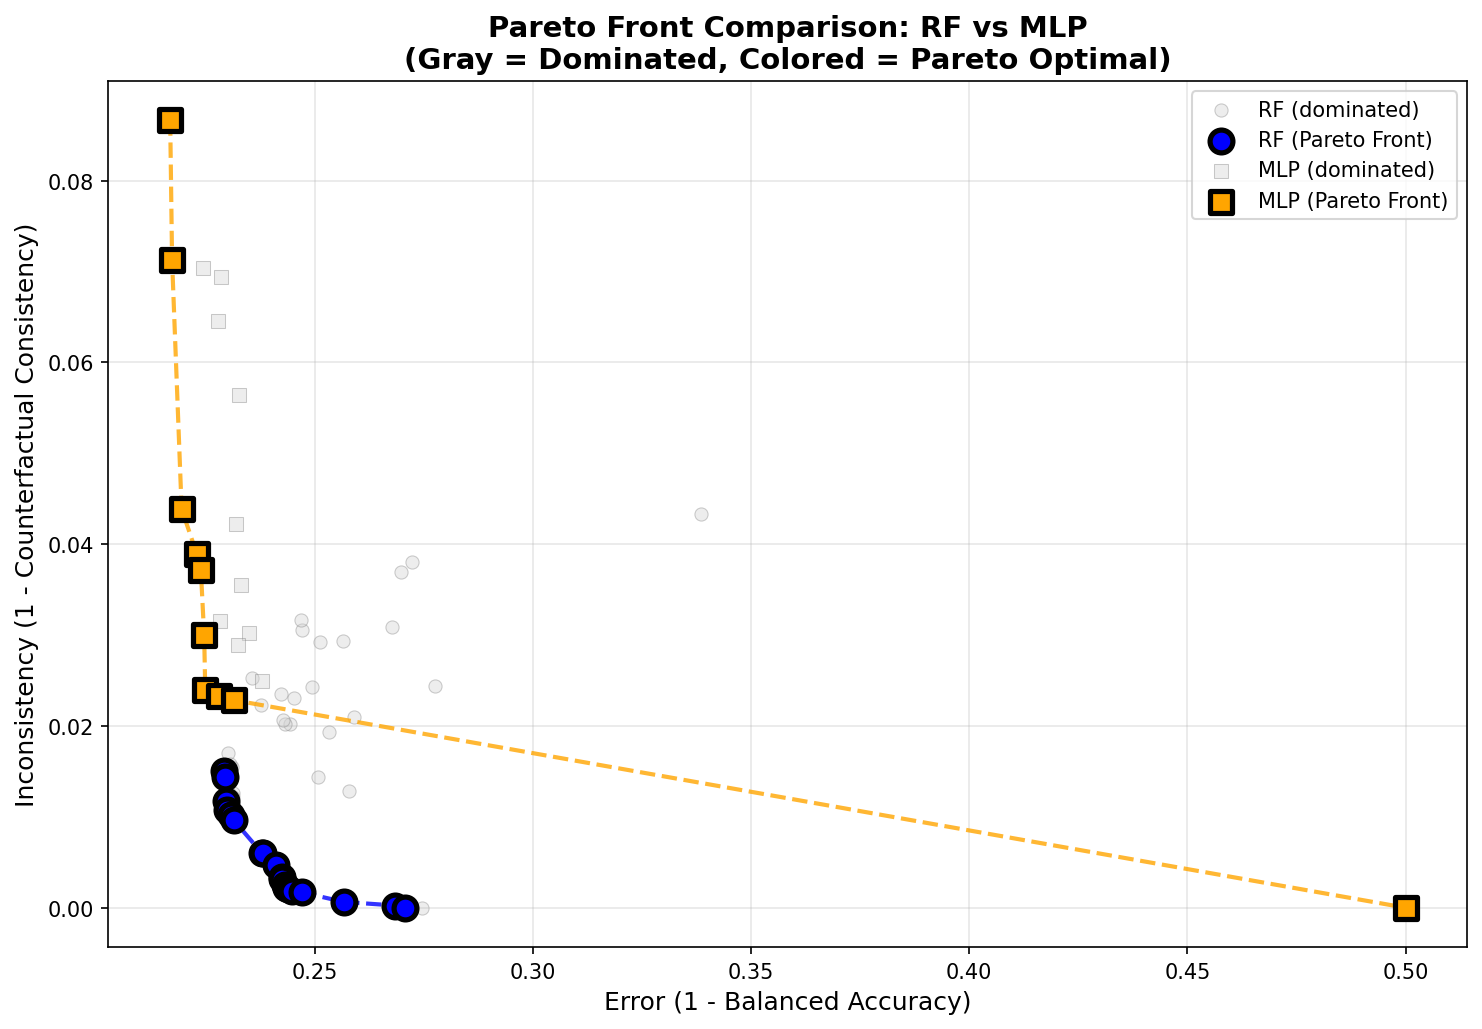

In [ ]:
# Generate Pareto comparison plot
pareto_path = f"{OUTPUT_DIR}/pareto_{DATASET_NAME}_{SENSITIVE_FEATURE}.png"
plot_pareto_comparison(results, output_path=pareto_path)

# Display the plot
display(Image(filename=pareto_path))


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_sex_rf.png

Random Forest - Parallel Coordinate Plot:


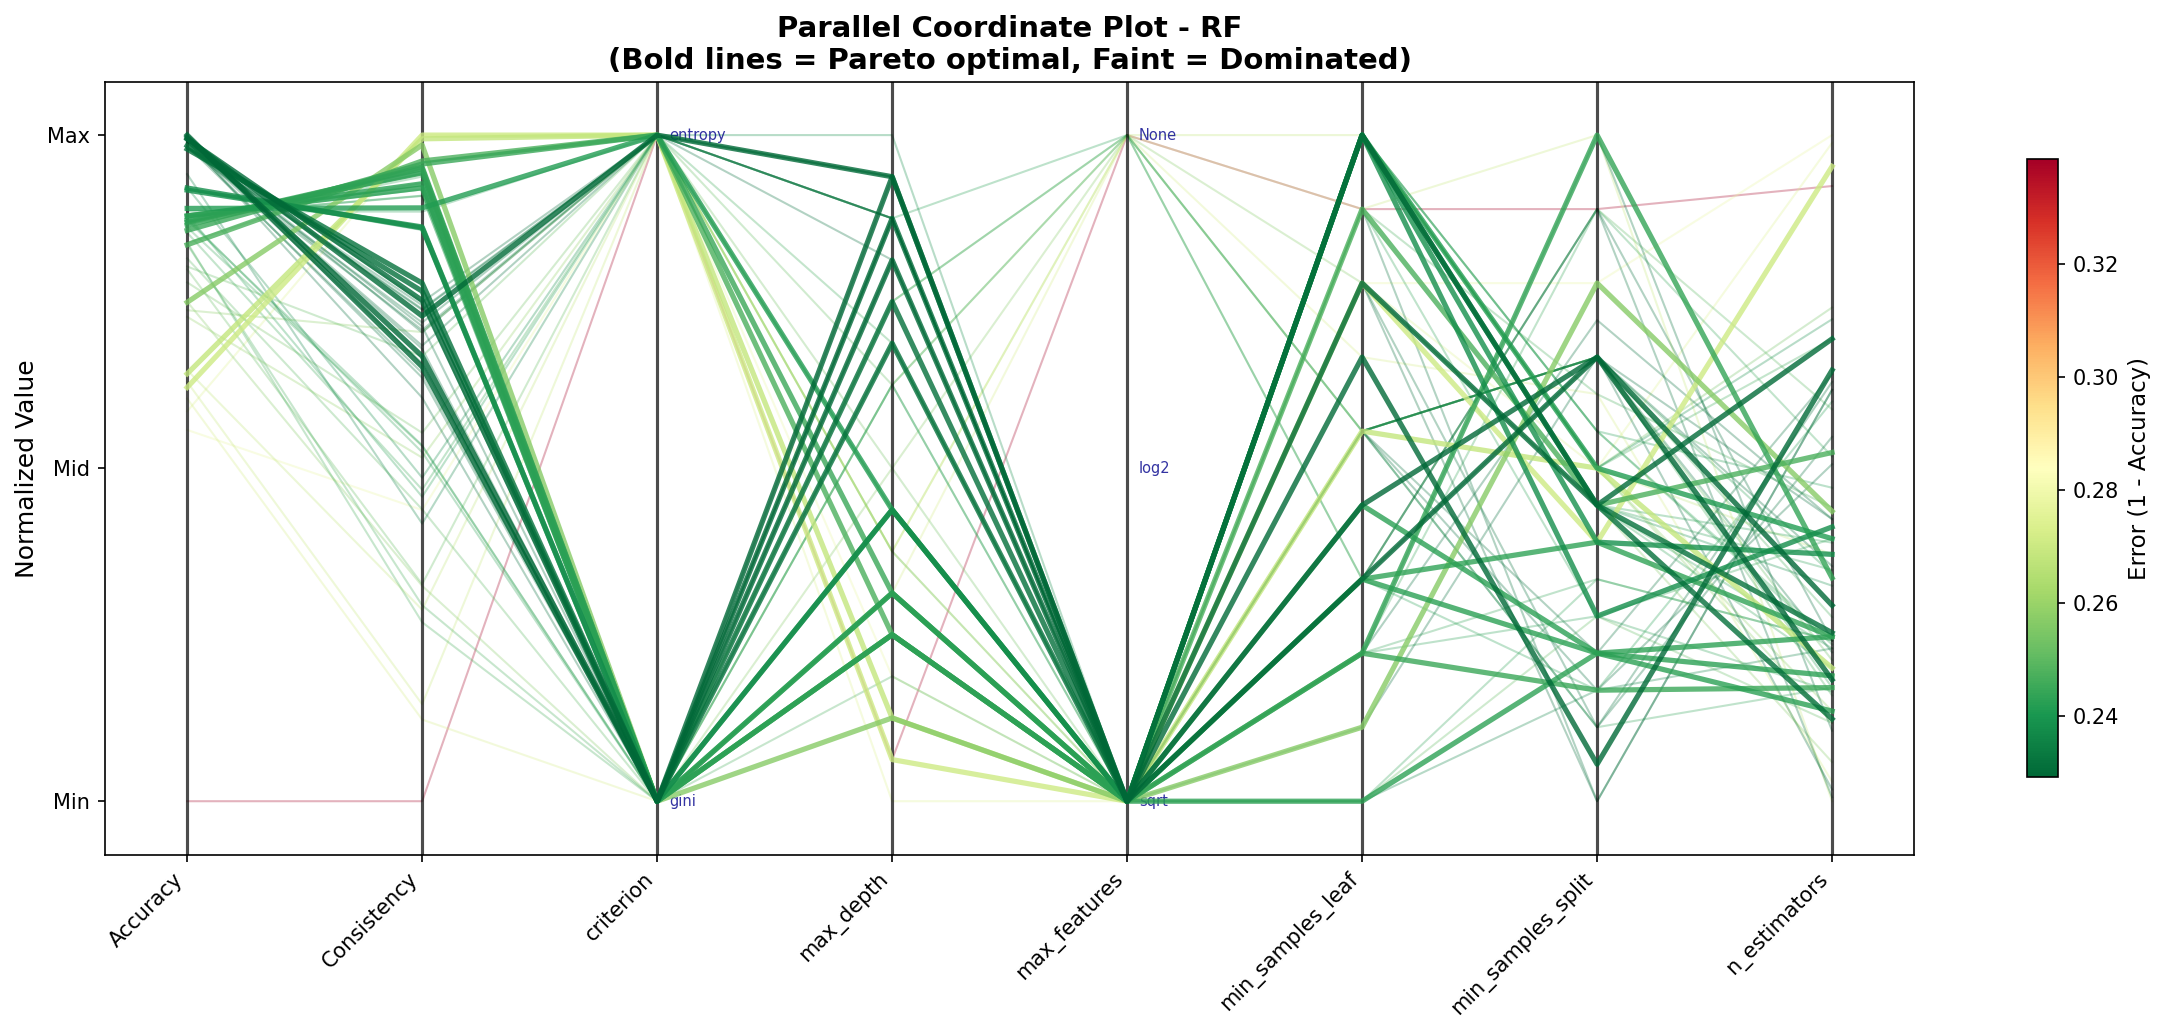

In [8]:
# Random Forest parallel coordinates
rf_parallel_path = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME}_{SENSITIVE_FEATURE}_rf.png"
plot_parallel_coordinates(results['rf'], 'rf', output_path=rf_parallel_path, color_by='error')

print("\nRandom Forest - Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_path))


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_sex_mlp.png

MLP - Parallel Coordinate Plot:


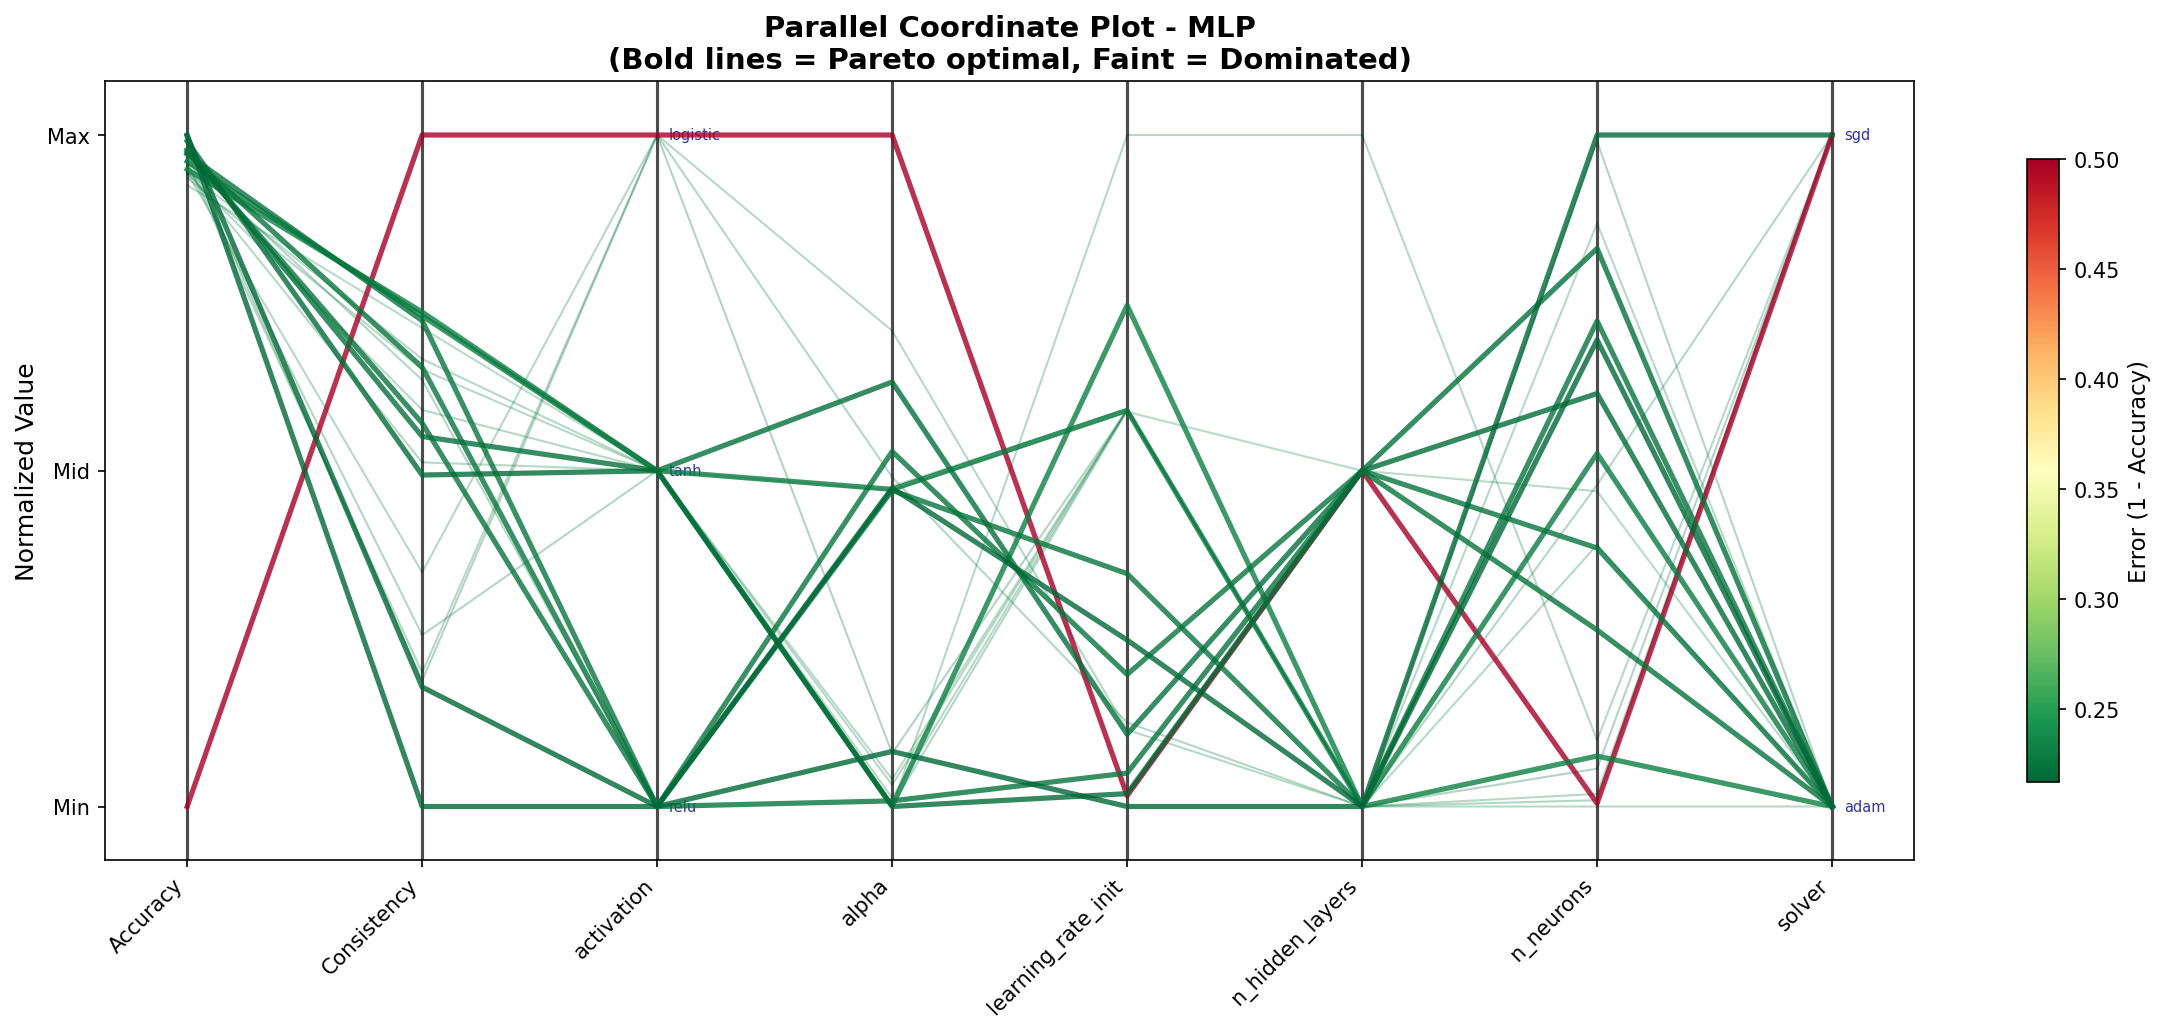

In [9]:
# MLP parallel coordinates
mlp_parallel_path = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME}_{SENSITIVE_FEATURE}_mlp.png"
plot_parallel_coordinates(results['mlp'], 'mlp', output_path=mlp_parallel_path, color_by='error')

print("\nMLP - Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_path))


MDS projection plot saved to: ../plots/mds_projection_adult_sex_rf.png

Random Forest - MDS Projection:


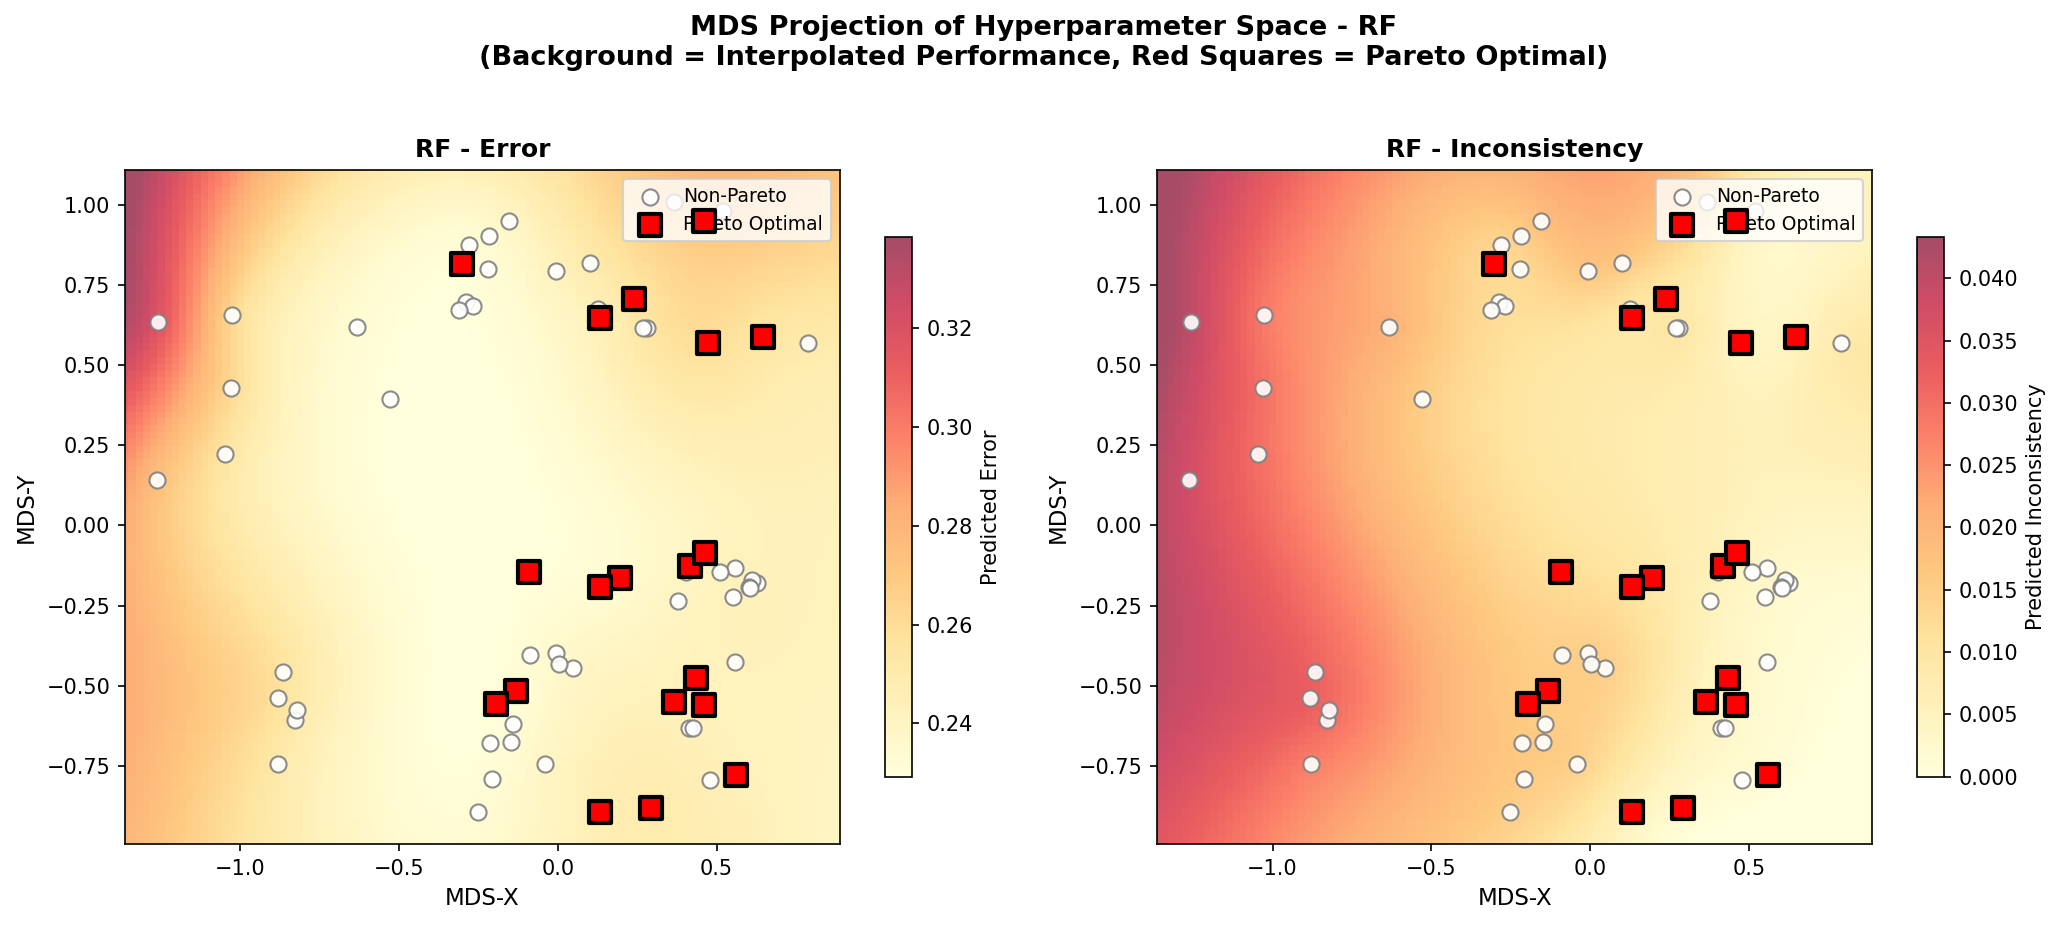

In [10]:
# Random Forest MDS projection
rf_mds_path = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME}_{SENSITIVE_FEATURE}_rf.png"
plot_mds_projection(results['rf'], 'rf', output_path=rf_mds_path)

print("\nRandom Forest - MDS Projection:")
display(Image(filename=rf_mds_path))


MDS projection plot saved to: ../plots/mds_projection_adult_sex_mlp.png

MLP - MDS Projection:


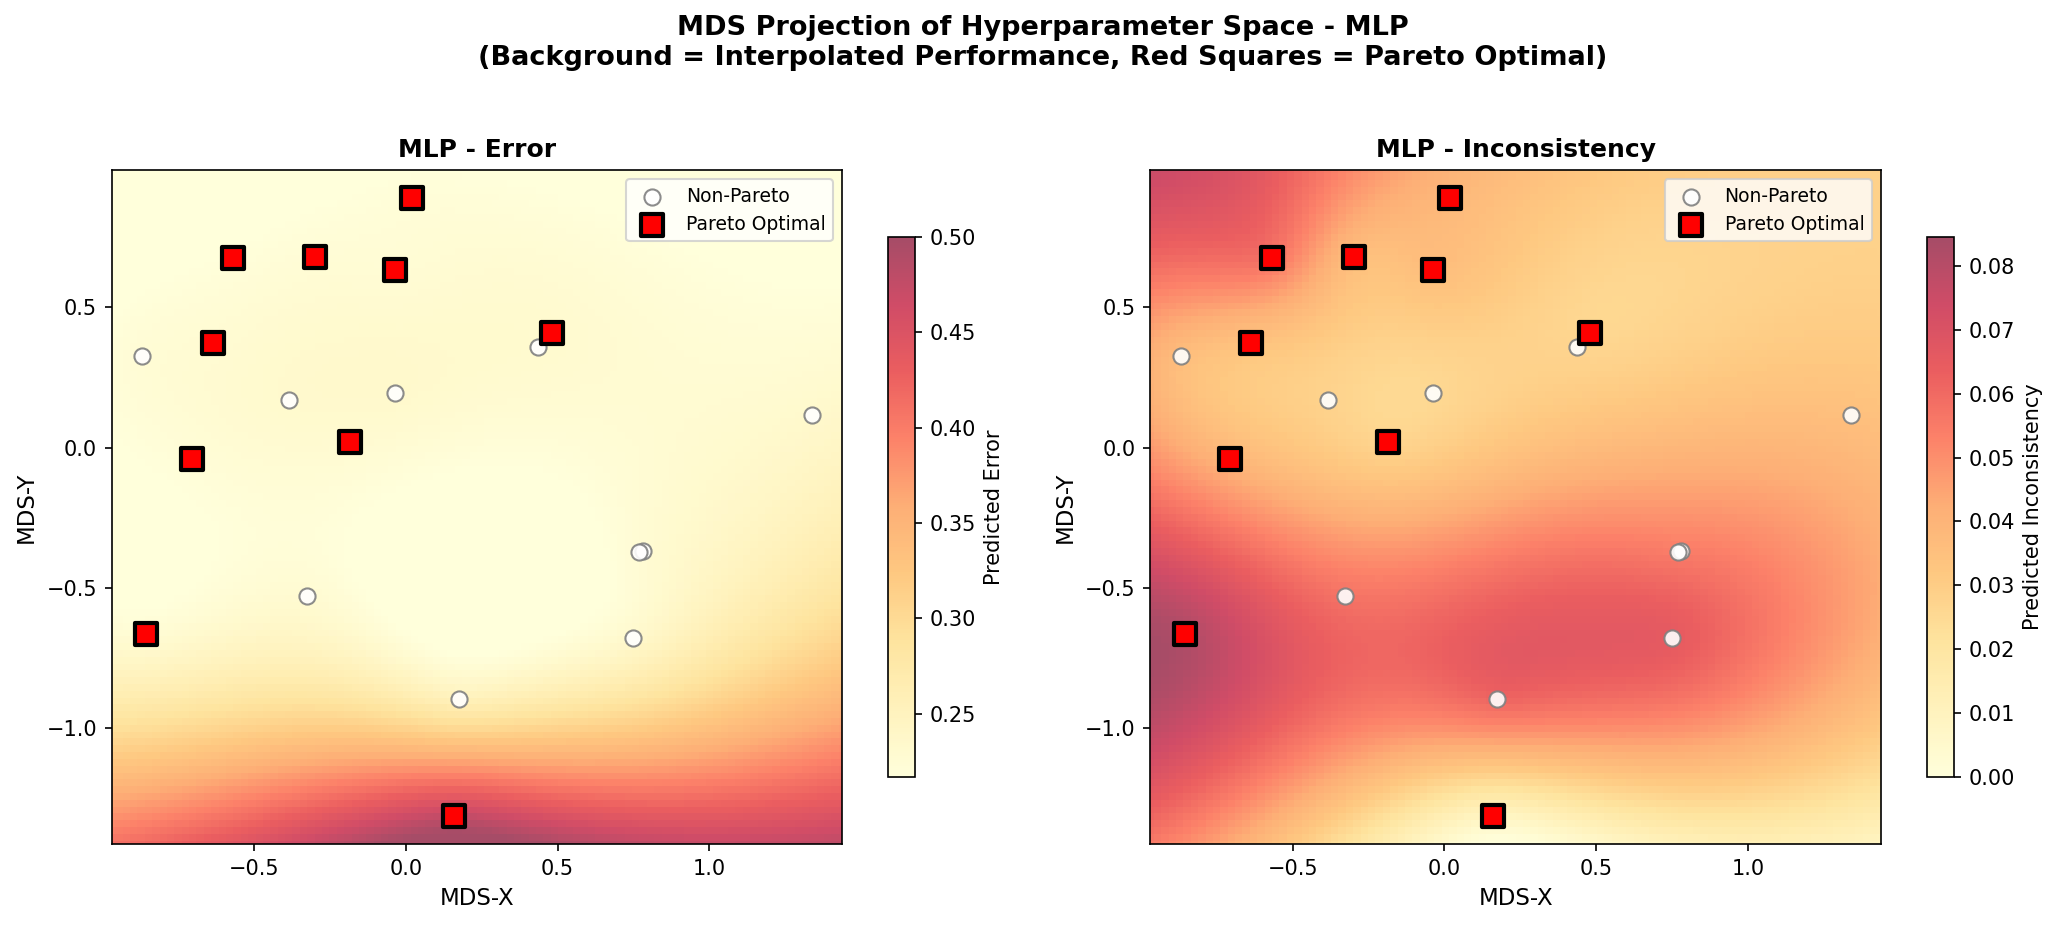

In [11]:
# MLP MDS projection
mlp_mds_path = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME}_{SENSITIVE_FEATURE}_mlp.png"
plot_mds_projection(results['mlp'], 'mlp', output_path=mlp_mds_path)

print("\nMLP - MDS Projection:")
display(Image(filename=mlp_mds_path))


## 9. Debug: Investigate the 50% Accuracy MLP

Let's manually test the "fairest" MLP configuration to understand why it has exactly 50% balanced accuracy. Let's look at the configuration with **minimum accuracy and maximum consistency** - this is often a "trivial" model that ignores features.

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import warnings

# Get the "fairest" MLP config
configs, costs = get_pareto_front(results['mlp'])
best_fair_idx = np.argmin(costs[:, 1])
fair_config = configs[best_fair_idx]

print("="*60)
print("DEBUGGING: Recreating the 'fairest' MLP manually")
print("="*60)
print(f"\nConfiguration:")
for key, value in dict(fair_config).items():
    print(f"  {key}: {value}")

# Create the MLP with the same hyperparameters
hidden_layer_sizes = tuple([fair_config["n_neurons"]] * fair_config["n_hidden_layers"])

mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=fair_config["activation"],
    solver=fair_config["solver"],
    alpha=fair_config["alpha"],
    learning_rate_init=fair_config["learning_rate_init"],
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)

# Split data for testing
X_train_debug, X_test_debug, y_train_debug, y_test_debug = train_test_split(
    data['X_train'], data['y_train'], test_size=0.2, random_state=42, stratify=data['y_train']
)

print(f"\n--- Data Info ---")
print(f"X_train shape: {X_train_debug.shape}")
print(f"y_train distribution: {np.bincount(y_train_debug)}")
print(f"y_train positive rate: {y_train_debug.mean():.2%}")

# Train the model
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    mlp.fit(X_train_debug, y_train_debug)
    
    # Check for convergence warnings
    if w:
        print(f"\n--- Warnings during training ---")
        for warning in w:
            print(f"  {warning.message}")

print(f"\n--- Training Info ---")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Loss: {mlp.loss_:.4f}")
print(f"Best validation score: {mlp.best_validation_score_:.4f}" if hasattr(mlp, 'best_validation_score_') else "N/A")

# Check predictions
y_pred = mlp.predict(X_test_debug)
print(f"\n--- Prediction Analysis ---")
print(f"Unique predictions: {np.unique(y_pred)}")
print(f"Prediction distribution: {np.bincount(y_pred)}")
print(f"% predicting class 0: {(y_pred == 0).mean():.2%}")
print(f"% predicting class 1: {(y_pred == 1).mean():.2%}")

# Check balanced accuracy
ba = balanced_accuracy_score(y_test_debug, y_pred)
print(f"\n--- Performance ---")
print(f"Balanced Accuracy: {ba:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_debug, y_pred, target_names=['<=50K', '>50K']))

# Check counterfactual consistency
from utils.datasets import create_flipped_data
X_test_flipped = create_flipped_data(X_test_debug, data['sensitive_col_idx'])
y_pred_flipped = mlp.predict(X_test_flipped)
consistency = (y_pred == y_pred_flipped).mean()
print(f"\n--- Counterfactual Consistency ---")
print(f"Consistency: {consistency:.4f}")
print(f"Number of changed predictions: {(y_pred != y_pred_flipped).sum()}")


DEBUGGING: Recreating the 'fairest' MLP manually

Configuration:
  activation: logistic
  alpha: 0.0367256749032
  learning_rate_init: 0.0017044157706
  n_hidden_layers: 2
  n_neurons: 27
  solver: sgd

--- Data Info ---
X_train shape: (36177, 62)
y_train distribution: [27211  8966]
y_train positive rate: 24.78%

--- Training Info ---
Number of iterations: 12
Loss: 0.5593
Best validation score: 0.7521

--- Prediction Analysis ---
Unique predictions: [0]
Prediction distribution: [9045]
% predicting class 0: 100.00%
% predicting class 1: 0.00%

--- Performance ---
Balanced Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.75      1.00      0.86      6803
        >50K       0.00      0.00      0.00      2242

    accuracy                           0.75      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.57      0.75      0.65      9045


--- Counterfactual Consistency ---
Consistency: 1.000

In [35]:
# Test the "fairest" MLP config with multiple random seeds
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
import numpy as np

X_train = data['X_train']
y_train = data['y_train']

# The problematic config
fairest_config = {
    'hidden_layer_sizes': (27, 27),  # 2 hidden layers
    'activation': 'logistic',
    'solver': 'sgd',
    'alpha': 0.0367,
    'learning_rate_init': 0.0017,
    'max_iter': 500,
    'early_stopping': True,
    'n_iter_no_change': 10,
}

print("Testing fairest MLP with different random seeds:")
print("=" * 60)

results = []
for seed in [42, 123, 456, 789, 999]:
    model = MLPClassifier(**fairest_config, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    acc = balanced_accuracy_score(y_train, y_pred)
    unique_preds = np.unique(y_pred)
    results.append((seed, acc, len(unique_preds), model.n_iter_))
    print(f"Seed {seed}: Accuracy={acc:.4f}, Unique classes predicted: {len(unique_preds)}, Iterations: {model.n_iter_}")

print("\n" + "=" * 60)
print("CONCLUSION:")
if all(r[2] == 1 for r in results):
    print("→ ALL seeds produce single-class predictions")
    print("→ The problem is NOT initial weights - it's the hyperparameter combination!")
else:
    print("→ Some seeds work better - initial weights do matter")
    print("→ But this combination is still unreliable!")


Testing fairest MLP with different random seeds:
Seed 42: Accuracy=0.5000, Unique classes predicted: 1, Iterations: 12
Seed 123: Accuracy=0.5000, Unique classes predicted: 1, Iterations: 12
Seed 456: Accuracy=0.5000, Unique classes predicted: 1, Iterations: 12
Seed 789: Accuracy=0.5000, Unique classes predicted: 1, Iterations: 12
Seed 999: Accuracy=0.5000, Unique classes predicted: 1, Iterations: 12

CONCLUSION:
→ ALL seeds produce single-class predictions
→ The problem is NOT initial weights - it's the hyperparameter combination!


In [19]:
# What if we ONLY change the activation from 'logistic' to 'relu'?
# This shows the real culprit is the sigmoid activation causing vanishing gradients

print("Same config but with ReLU instead of Logistic:")
print("=" * 60)

relu_config = fairest_config.copy()
relu_config['activation'] = 'relu'

for seed in [42, 123, 456]:
    model = MLPClassifier(**relu_config, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    acc = balanced_accuracy_score(y_train, y_pred)
    unique_preds = np.unique(y_pred)
    print(f"Seed {seed}: Accuracy={acc:.4f}, Unique classes predicted: {len(unique_preds)}, Iterations: {model.n_iter_}")

print("\n→ ReLU doesn't have vanishing gradient problems, so even with")
print("   low learning rate + SGD, the network can still learn!")


Same config but with ReLU instead of Logistic:
Seed 42: Accuracy=0.7733, Unique classes predicted: 2, Iterations: 37
Seed 123: Accuracy=0.7590, Unique classes predicted: 2, Iterations: 50
Seed 456: Accuracy=0.7766, Unique classes predicted: 2, Iterations: 61

→ ReLU doesn't have vanishing gradient problems, so even with
   low learning rate + SGD, the network can still learn!


NEURAL NETWORK WEIGHT ANALYSIS

Network Architecture:
  Input layer: 62 features
  Hidden layer 1: 62 → 27 neurons
  Hidden layer 2: 27 → 27 neurons
  Output layer 3: 27 → 1 neurons

Training stopped after 12 iterations

----------------------------------------------------------------------
WEIGHT STATISTICS PER LAYER:
----------------------------------------------------------------------

Layer 1 (shape: (62, 27)):
  Weights - Min: -0.148692, Max: 0.149804, Mean: -0.000064, Std: 0.087719
  Biases  - Min: -0.142107, Max: 0.142627, Mean: -0.002048

Layer 2 (shape: (27, 27)):
  Weights - Min: -0.194914, Max: 0.197260, Mean: -0.002433, Std: 0.110533
  Biases  - Min: -0.177087, Max: 0.190751, Mean: -0.006030

Output Layer (shape: (27, 1)):
  Weights - Min: -0.334407, Max: 0.180846, Mean: -0.060399, Std: 0.157473
  Biases  - Min: -0.211508, Max: -0.211508, Mean: -0.211508


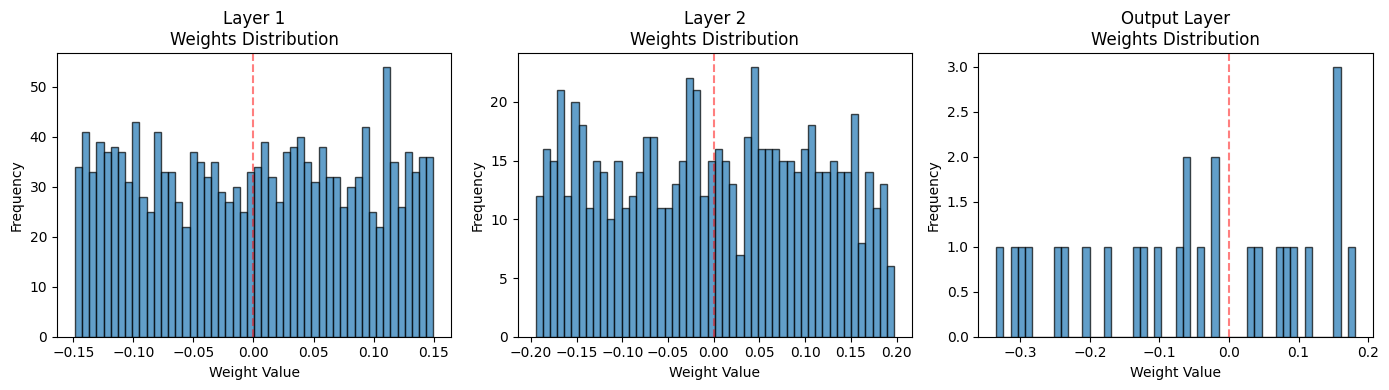


DIAGNOSIS:
Total weights: 2430
Weights with |value| < 0.1: 1486 (61.2%)

→ Small weights + sigmoid activation = outputs near 0.5 for all samples
→ The network never learned to distinguish between classes!


In [ ]:
# Analyze the final weights of the "fairest" MLP
import matplotlib.pyplot as plt

# Train the fairest model again to inspect weights
model_to_inspect = MLPClassifier(**fairest_config, random_state=42)
model_to_inspect.fit(X_train, y_train)

print("=" * 70)
print("NEURAL NETWORK WEIGHT ANALYSIS")
print("=" * 70)

# Show network architecture
print(f"\nNetwork Architecture:")
print(f"  Input layer: {X_train.shape[1]} features")
for i, (coef, intercept) in enumerate(zip(model_to_inspect.coefs_, model_to_inspect.intercepts_)):
    layer_type = "Hidden" if i < len(model_to_inspect.coefs_) - 1 else "Output"
    print(f"  {layer_type} layer {i+1}: {coef.shape[0]} → {coef.shape[1]} neurons")

print(f"\nTraining stopped after {model_to_inspect.n_iter_} iterations")

# Analyze each layer's weights
print("\n" + "-" * 70)
print("WEIGHT STATISTICS PER LAYER:")
print("-" * 70)

fig, axes = plt.subplots(1, len(model_to_inspect.coefs_), figsize=(14, 4))
if len(model_to_inspect.coefs_) == 1:
    axes = [axes]

for i, (coef, intercept) in enumerate(zip(model_to_inspect.coefs_, model_to_inspect.intercepts_)):
    layer_name = f"Layer {i+1}" if i < len(model_to_inspect.coefs_) - 1 else "Output Layer"
    
    print(f"\n{layer_name} (shape: {coef.shape}):")
    print(f"  Weights - Min: {coef.min():.6f}, Max: {coef.max():.6f}, Mean: {coef.mean():.6f}, Std: {coef.std():.6f}")
    print(f"  Biases  - Min: {intercept.min():.6f}, Max: {intercept.max():.6f}, Mean: {intercept.mean():.6f}")
    
    # Histogram of weights
    axes[i].hist(coef.flatten(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{layer_name}\nWeights Distribution')
    axes[i].set_xlabel('Weight Value')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../plots/fairest_mlp_weights.png', dpi=150, bbox_inches='tight')
plt.show()

# Check if weights are essentially at initialization values
print("\n" + "=" * 70)
print("DIAGNOSIS:")
print("=" * 70)
total_weights = sum(c.size for c in model_to_inspect.coefs_)
small_weights = sum((np.abs(c) < 0.1).sum() for c in model_to_inspect.coefs_)
print(f"Total weights: {total_weights}")
print(f"Weights with |value| < 0.1: {small_weights} ({100*small_weights/total_weights:.1f}%)")
print(f"\n→ Small weights + sigmoid activation = outputs near 0.5 for all samples")
print(f"→ The network never learned to distinguish between classes!")


OUTPUT PROBABILITY ANALYSIS

Probability for class 1 (>50K income):
  Min:  0.241905
  Max:  0.248998
  Mean: 0.246083
  Std:  0.000846


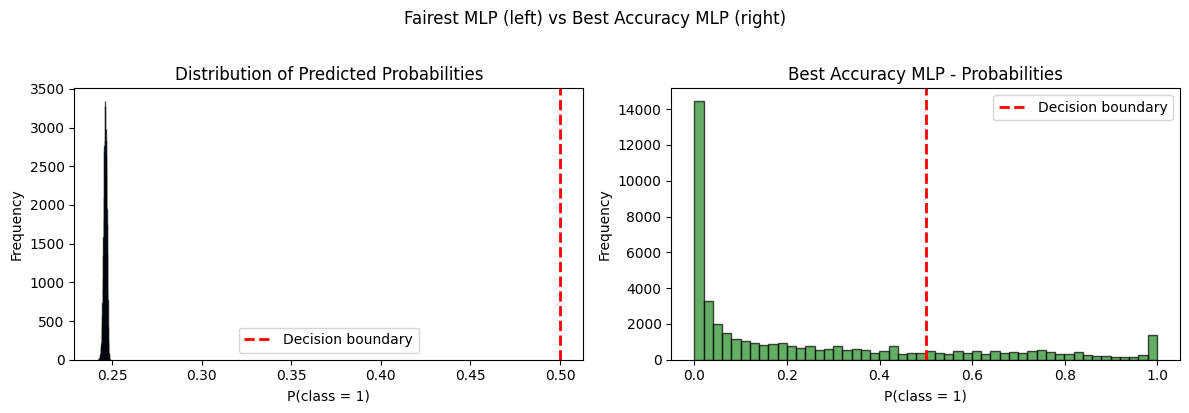


KEY INSIGHT:
→ Fairest MLP: All probabilities are on ONE side of 0.5 → single class prediction
→ Good MLP: Probabilities span BOTH sides of 0.5 → can predict both classes
→ The fairest model's sigmoid outputs are 'stuck' due to vanishing gradients!


In [21]:
# Look at the output probabilities - this shows why it predicts only one class
proba = model_to_inspect.predict_proba(X_train)

print("=" * 70)
print("OUTPUT PROBABILITY ANALYSIS")
print("=" * 70)

print(f"\nProbability for class 1 (>50K income):")
print(f"  Min:  {proba[:, 1].min():.6f}")
print(f"  Max:  {proba[:, 1].max():.6f}")
print(f"  Mean: {proba[:, 1].mean():.6f}")
print(f"  Std:  {proba[:, 1].std():.6f}")

# Plot distribution of probabilities
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of P(class=1)
axes[0].hist(proba[:, 1], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision boundary')
axes[0].set_xlabel('P(class = 1)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Probabilities')
axes[0].legend()

# Compare to a working model (the best accuracy one)
best_acc_config = {
    'hidden_layer_sizes': (239,),  # 1 hidden layer
    'activation': 'relu',
    'solver': 'sgd',
    'alpha': 0.0174,
    'learning_rate_init': 0.0232,
    'max_iter': 1000,
    'early_stopping': True,
    'n_iter_no_change': 10,
    'random_state': 42
}
good_model = MLPClassifier(**best_acc_config)
good_model.fit(X_train, y_train)
good_proba = good_model.predict_proba(X_train)

axes[1].hist(good_proba[:, 1], bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision boundary')
axes[1].set_xlabel('P(class = 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Best Accuracy MLP - Probabilities')
axes[1].legend()

plt.suptitle('Fairest MLP (left) vs Best Accuracy MLP (right)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig('../plots/mlp_probability_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHT:")
print("=" * 70)
print("→ Fairest MLP: All probabilities are on ONE side of 0.5 → single class prediction")
print("→ Good MLP: Probabilities span BOTH sides of 0.5 → can predict both classes")
print("→ The fairest model's sigmoid outputs are 'stuck' due to vanishing gradients!")


## 🔬 Analysis: The "Trivial Fairness" Problem

### Observation: 100% Consistency but 50% Accuracy

The SMAC optimization found an MLP configuration that achieves **perfect counterfactual consistency (100%)** but only **50% balanced accuracy** (equivalent to random guessing). This is a **degenerate solution** - a model that appears maximally fair but provides no useful predictions.

### The Configuration

| Hyperparameter | Value | Impact |
|---------------|-------|--------|
| `activation` | `logistic` (sigmoid) | **Main culprit** - causes vanishing gradients |
| `solver` | `sgd` | No momentum to escape flat regions |
| `learning_rate_init` | `0.0017` | Very low - tiny weight updates |
| `alpha` | `0.0367` | High L2 regularization - pushes weights to zero |
| `hidden_layer_sizes` | `(27, 27)` | 2 hidden layers - gradients multiply through both |

### Root Cause: Vanishing Gradient Problem

**The sigmoid activation function has a maximum gradient of only 0.25:**

$$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x)) \leq 0.25$$

**In a 2-layer network, gradients compound:**

$$\text{Effective gradient} \approx 0.25 \times 0.25 = 0.0625 \text{ (6.25% of original)}$$

**Combined with other factors:**

$$\text{Weight update} = \underbrace{0.0625}_{\text{sigmoid}} \times \underbrace{0.0017}_{\text{lr}} \times \underbrace{(1 - 0.0367)}_{\text{L2}} \approx 0.0001$$

### Evidence from Our Analysis

1. **Training stopped after only 12 iterations** - early stopping triggered because loss plateaued
2. **61.2% of weights remain < 0.1** - weights never grew from initialization
3. **All output probabilities in [0.242, 0.249]** - all below 0.5, predicting class 0 for everyone
4. **Probability std = 0.000846** - essentially no variation between samples

### Why This Matters for Fairness Research

This is a **false positive for fairness**: the model achieves perfect consistency not because it learned to be fair, but because it **learned nothing at all**. A constant predictor trivially satisfies:

$$\text{Consistency} = \frac{\sum \mathbb{1}[f(x) = f(x')]}{n} = 1.0 \quad \text{when } f(x) = c \text{ for all } x$$

### Key Takeaway

> ⚠️ **When evaluating fairness metrics, always check model accuracy first.** A model with very high fairness but near-random accuracy may be a degenerate solution that provides no value.

### Verification: ReLU Fixes the Problem

Changing **only** the activation from `logistic` to `relu` (keeping all else the same) allows the network to learn:
- ReLU gradient = 1 (for positive inputs) vs sigmoid's max of 0.25
- The model achieves ~75% accuracy with the same hyperparameters
- This confirms the sigmoid activation was the bottleneck


## 📊 Case Study Analysis for Report

The following cells analyze specific samples to illustrate fairness concepts.


In [27]:
# Setup: Train both best accuracy models for comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np

# Best accuracy RF (from our optimization)
rf_model = RandomForestClassifier(
    n_estimators=66, max_depth=19, min_samples_split=14,
    min_samples_leaf=4, criterion='gini', random_state=42
)
rf_model.fit(X_train, y_train)

# Best accuracy MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(239,), activation='relu', solver='sgd',
    alpha=0.0174, learning_rate_init=0.0232, max_iter=1000,
    early_stopping=True, random_state=42
)
mlp_model.fit(X_train, y_train)

# Create flipped data (sex column)
from utils.datasets import create_flipped_data
X_train_flipped = create_flipped_data(X_train, data['sensitive_col_idx'])

# Get predictions for both original and flipped
rf_pred_orig = rf_model.predict(X_train)
rf_pred_flip = rf_model.predict(X_train_flipped)
rf_proba_orig = rf_model.predict_proba(X_train)[:, 1]
rf_proba_flip = rf_model.predict_proba(X_train_flipped)[:, 1]

mlp_pred_orig = mlp_model.predict(X_train)
mlp_pred_flip = mlp_model.predict(X_train_flipped)
mlp_proba_orig = mlp_model.predict_proba(X_train)[:, 1]
mlp_proba_flip = mlp_model.predict_proba(X_train_flipped)[:, 1]

# Find inconsistent samples for each model
rf_inconsistent = rf_pred_orig != rf_pred_flip
mlp_inconsistent = mlp_pred_orig != mlp_pred_flip

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"Total samples: {len(X_train)}")
print(f"RF inconsistent samples: {rf_inconsistent.sum()} ({100*rf_inconsistent.mean():.2f}%)")
print(f"MLP inconsistent samples: {mlp_inconsistent.sum()} ({100*mlp_inconsistent.mean():.2f}%)")


DATASET OVERVIEW
Total samples: 45222
RF inconsistent samples: 988 (2.18%)
MLP inconsistent samples: 4345 (9.61%)


In [29]:
# ============================================================================
# CASE STUDY 1: Sample where changing sex FLIPS the prediction
# ============================================================================
# Find a sample where RF prediction changes when sex is flipped

# Get feature names for interpretation
feature_names = list(X_train.columns) if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Find inconsistent sample indices
rf_flip_indices = np.where(rf_inconsistent)[0]

if len(rf_flip_indices) > 0:
    # Pick one example
    idx = rf_flip_indices[0]
    
    print("=" * 70)
    print("CASE STUDY 1: Prediction Flip When Sex Changes (RF Model)")
    print("=" * 70)
    print(f"\nSample Index: {idx}")
    print(f"True Label: {'High Income (>50K)' if y_train[idx] == 1 else 'Low Income (<=50K)'}")
    
    print(f"\n--- Original Sample ---")
    print(f"Prediction: {'High Income' if rf_pred_orig[idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_orig[idx]:.4f}")
    
    print(f"\n--- After Flipping Sex ---")
    print(f"Prediction: {'High Income' if rf_pred_flip[idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_flip[idx]:.4f}")
    
    print(f"\n--- Probability Change ---")
    print(f"ΔP = {rf_proba_flip[idx] - rf_proba_orig[idx]:.4f}")
    
    # Show the sex feature value
    sex_col_idx = [i for i, name in enumerate(feature_names) if 'sex' in name.lower()]
    if sex_col_idx:
        orig_val = X_train.iloc[idx, sex_col_idx[0]] if hasattr(X_train, 'iloc') else X_train[idx, sex_col_idx[0]]
        flip_val = X_train_flipped[idx, sex_col_idx[0]] if isinstance(X_train_flipped, np.ndarray) else X_train_flipped.iloc[idx, sex_col_idx[0]]
        print(f"\nSex feature '{feature_names[sex_col_idx[0]]}': {orig_val} → {flip_val}")
else:
    print("No inconsistent samples found for RF!")


CASE STUDY 1: Prediction Flip When Sex Changes (RF Model)

Sample Index: 4
True Label: Low Income (<=50K)

--- Original Sample ---
Prediction: High Income
Confidence P(High Income): 0.5407

--- After Flipping Sex ---
Prediction: Low Income
Confidence P(High Income): 0.4959

--- Probability Change ---
ΔP = -0.0448


In [30]:
# ============================================================================
# CASE STUDY 2: Sample that STAYS CONSISTENT (for contrast)
# ============================================================================
# Find a sample where prediction stays the same when sex is flipped

rf_consistent_indices = np.where(~rf_inconsistent)[0]

if len(rf_consistent_indices) > 0:
    # Pick a high-confidence consistent sample
    consistent_proba = rf_proba_orig[rf_consistent_indices]
    # Find one with high confidence (far from 0.5)
    high_conf_idx = rf_consistent_indices[np.argmax(np.abs(consistent_proba - 0.5))]
    
    print("\n" + "=" * 70)
    print("CASE STUDY 2: Consistent Prediction (Sex Change Has No Effect)")
    print("=" * 70)
    print(f"\nSample Index: {high_conf_idx}")
    print(f"True Label: {'High Income' if y_train[high_conf_idx] == 1 else 'Low Income'}")
    
    print(f"\n--- Original Sample ---")
    print(f"Prediction: {'High Income' if rf_pred_orig[high_conf_idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_orig[high_conf_idx]:.4f}")
    
    print(f"\n--- After Flipping Sex ---")
    print(f"Prediction: {'High Income' if rf_pred_flip[high_conf_idx] == 1 else 'Low Income'}")
    print(f"Confidence P(High Income): {rf_proba_flip[high_conf_idx]:.4f}")
    
    print(f"\n✓ This sample's prediction is ROBUST to sex changes")
    print(f"  The model relies on other features (education, occupation, etc.)")



CASE STUDY 2: Consistent Prediction (Sex Change Has No Effect)

Sample Index: 28345
True Label: Low Income

--- Original Sample ---
Prediction: Low Income
Confidence P(High Income): 0.0000

--- After Flipping Sex ---
Prediction: Low Income
Confidence P(High Income): 0.0023

✓ This sample's prediction is ROBUST to sex changes
  The model relies on other features (education, occupation, etc.)


In [31]:
# ============================================================================
# CASE STUDY 3: Edge Case - Sample NEAR Decision Boundary
# ============================================================================
# Find samples where probability is close to 0.5 (uncertain predictions)

boundary_dist = np.abs(rf_proba_orig - 0.5)
near_boundary = boundary_dist < 0.1  # Within 10% of boundary

print("\n" + "=" * 70)
print("CASE STUDY 3: Edge Cases Near Decision Boundary")
print("=" * 70)

print(f"\nSamples within 10% of decision boundary: {near_boundary.sum()}")
print(f"Of these, inconsistent when sex flipped: {(near_boundary & rf_inconsistent).sum()}")
print(f"Inconsistency rate near boundary: {100*(near_boundary & rf_inconsistent).sum()/near_boundary.sum():.1f}%")
print(f"Inconsistency rate overall: {100*rf_inconsistent.mean():.1f}%")

# Pick an edge case example
edge_indices = np.where(near_boundary & rf_inconsistent)[0]
if len(edge_indices) > 0:
    edge_idx = edge_indices[0]
    print(f"\n--- Example Edge Case (Index {edge_idx}) ---")
    print(f"Original P(High Income): {rf_proba_orig[edge_idx]:.4f} (very uncertain!)")
    print(f"Flipped P(High Income):  {rf_proba_flip[edge_idx]:.4f}")
    print(f"Prediction: {'High Income' if rf_pred_orig[edge_idx] == 1 else 'Low Income'} → {'High Income' if rf_pred_flip[edge_idx] == 1 else 'Low Income'}")
    print(f"\n→ Edge cases are MORE vulnerable to bias - small changes flip predictions!")



CASE STUDY 3: Edge Cases Near Decision Boundary

Samples within 10% of decision boundary: 4987
Of these, inconsistent when sex flipped: 986
Inconsistency rate near boundary: 19.8%
Inconsistency rate overall: 2.2%

--- Example Edge Case (Index 4) ---
Original P(High Income): 0.5407 (very uncertain!)
Flipped P(High Income):  0.4959
Prediction: High Income → Low Income

→ Edge cases are MORE vulnerable to bias - small changes flip predictions!


In [32]:
# ============================================================================
# CASE STUDY 4: RF vs MLP on SAME Sample
# ============================================================================
# Find a sample where models disagree on consistency

rf_only_inconsistent = rf_inconsistent & ~mlp_inconsistent
mlp_only_inconsistent = ~rf_inconsistent & mlp_inconsistent
both_inconsistent = rf_inconsistent & mlp_inconsistent

print("\n" + "=" * 70)
print("CASE STUDY 4: Comparing RF vs MLP Fairness on Same Samples")
print("=" * 70)

print(f"\nOnly RF inconsistent: {rf_only_inconsistent.sum()}")
print(f"Only MLP inconsistent: {mlp_only_inconsistent.sum()}")
print(f"Both models inconsistent: {both_inconsistent.sum()}")
print(f"Both models consistent: {(~rf_inconsistent & ~mlp_inconsistent).sum()}")

# Example where RF is unfair but MLP is fair
if rf_only_inconsistent.sum() > 0:
    idx = np.where(rf_only_inconsistent)[0][0]
    print(f"\n--- Sample {idx}: RF Unfair, MLP Fair ---")
    print(f"RF:  P={rf_proba_orig[idx]:.3f} → {rf_proba_flip[idx]:.3f} | Pred: {rf_pred_orig[idx]} → {rf_pred_flip[idx]} ✗")
    print(f"MLP: P={mlp_proba_orig[idx]:.3f} → {mlp_proba_flip[idx]:.3f} | Pred: {mlp_pred_orig[idx]} → {mlp_pred_flip[idx]} ✓")

# Example where MLP is unfair but RF is fair
if mlp_only_inconsistent.sum() > 0:
    idx = np.where(mlp_only_inconsistent)[0][0]
    print(f"\n--- Sample {idx}: MLP Unfair, RF Fair ---")
    print(f"RF:  P={rf_proba_orig[idx]:.3f} → {rf_proba_flip[idx]:.3f} | Pred: {rf_pred_orig[idx]} → {rf_pred_flip[idx]} ✓")
    print(f"MLP: P={mlp_proba_orig[idx]:.3f} → {mlp_proba_flip[idx]:.3f} | Pred: {mlp_pred_orig[idx]} → {mlp_pred_flip[idx]} ✗")

print("\n→ Different models can be unfair to DIFFERENT individuals!")



CASE STUDY 4: Comparing RF vs MLP Fairness on Same Samples

Only RF inconsistent: 298
Only MLP inconsistent: 3655
Both models inconsistent: 690
Both models consistent: 40579

--- Sample 4: RF Unfair, MLP Fair ---
RF:  P=0.541 → 0.496 | Pred: 1 → 0 ✗
MLP: P=0.573 → 0.752 | Pred: 1 → 1 ✓

--- Sample 10: MLP Unfair, RF Fair ---
RF:  P=0.563 → 0.528 | Pred: 1 → 1 ✓
MLP: P=0.626 → 0.408 | Pred: 1 → 0 ✗

→ Different models can be unfair to DIFFERENT individuals!


In [33]:
# ============================================================================
# CASE STUDY 5: Largest Probability Swing
# ============================================================================
# Find the sample with the largest change in probability when sex is flipped

rf_proba_change = np.abs(rf_proba_flip - rf_proba_orig)
mlp_proba_change = np.abs(mlp_proba_flip - mlp_proba_orig)

print("\n" + "=" * 70)
print("CASE STUDY 5: Largest Probability Swings")
print("=" * 70)

# RF largest swing
rf_max_idx = np.argmax(rf_proba_change)
print(f"\n--- RF: Largest Probability Change ---")
print(f"Sample Index: {rf_max_idx}")
print(f"P(High Income): {rf_proba_orig[rf_max_idx]:.4f} → {rf_proba_flip[rf_max_idx]:.4f}")
print(f"Change: {rf_proba_change[rf_max_idx]:.4f} ({100*rf_proba_change[rf_max_idx]:.1f}%)")
print(f"Prediction flipped: {'Yes ✗' if rf_inconsistent[rf_max_idx] else 'No ✓'}")

# MLP largest swing
mlp_max_idx = np.argmax(mlp_proba_change)
print(f"\n--- MLP: Largest Probability Change ---")
print(f"Sample Index: {mlp_max_idx}")
print(f"P(High Income): {mlp_proba_orig[mlp_max_idx]:.4f} → {mlp_proba_flip[mlp_max_idx]:.4f}")
print(f"Change: {mlp_proba_change[mlp_max_idx]:.4f} ({100*mlp_proba_change[mlp_max_idx]:.1f}%)")
print(f"Prediction flipped: {'Yes ✗' if mlp_inconsistent[mlp_max_idx] else 'No ✓'}")

print(f"\n→ Even without flipping predictions, large probability changes indicate sensitivity to sex!")



CASE STUDY 5: Largest Probability Swings

--- RF: Largest Probability Change ---
Sample Index: 26658
P(High Income): 0.2724 → 0.4551
Change: 0.1827 (18.3%)
Prediction flipped: No ✓

--- MLP: Largest Probability Change ---
Sample Index: 5968
P(High Income): 0.6971 → 0.3648
Change: 0.3323 (33.2%)
Prediction flipped: Yes ✗

→ Even without flipping predictions, large probability changes indicate sensitivity to sex!


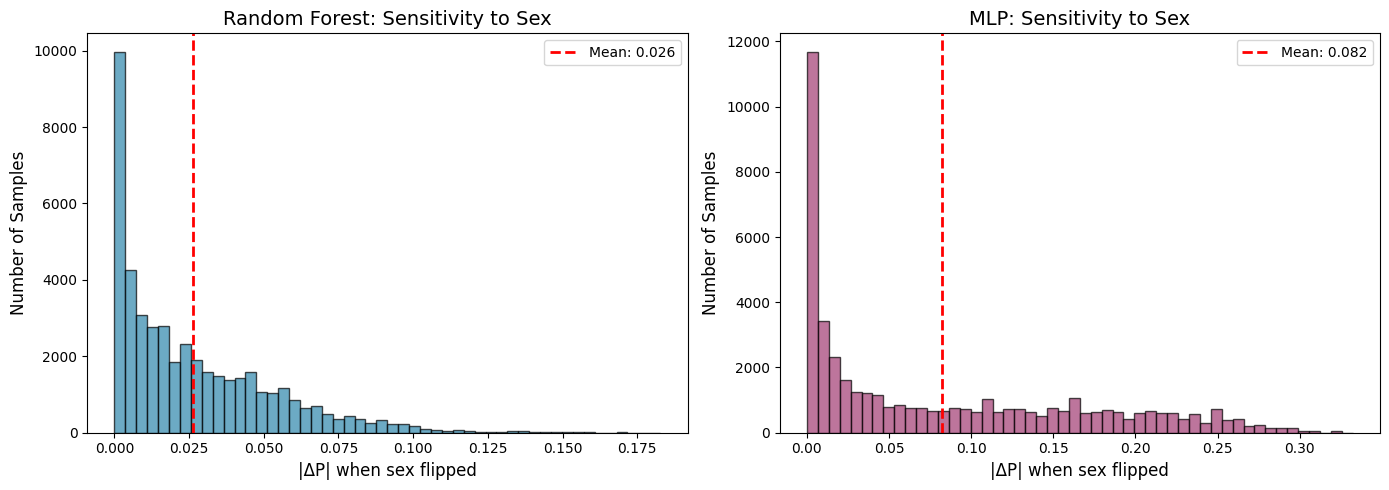

RF  - Mean |ΔP|: 0.0263, Max: 0.1827
MLP - Mean |ΔP|: 0.0825, Max: 0.3323


In [34]:
# ============================================================================
# VISUALIZATION: Probability Change Distribution
# ============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RF probability change distribution
axes[0].hist(rf_proba_change, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0].axvline(x=rf_proba_change.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {rf_proba_change.mean():.3f}')
axes[0].set_xlabel('|ΔP| when sex flipped', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Random Forest: Sensitivity to Sex', fontsize=14)
axes[0].legend()

# MLP probability change distribution
axes[1].hist(mlp_proba_change, bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[1].axvline(x=mlp_proba_change.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mlp_proba_change.mean():.3f}')
axes[1].set_xlabel('|ΔP| when sex flipped', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('MLP: Sensitivity to Sex', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.savefig('../plots/probability_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"RF  - Mean |ΔP|: {rf_proba_change.mean():.4f}, Max: {rf_proba_change.max():.4f}")
print(f"MLP - Mean |ΔP|: {mlp_proba_change.mean():.4f}, Max: {mlp_proba_change.max():.4f}")


In [ ]:
# ============================================================================
# VISUALIZATION: Original vs Flipped Probability Scatter
# ============================================================================
# This is a powerful visualization showing how predictions change

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RF scatter
scatter1 = axes[0].scatter(rf_proba_orig, rf_proba_flip, 
                           c=rf_inconsistent.astype(int), cmap='coolwarm',
                           alpha=0.5, s=10)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect consistency')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('P(High Income) - Original', fontsize=12)
axes[0].set_ylabel('P(High Income) - Sex Flipped', fontsize=12)
axes[0].set_title('Random Forest: Counterfactual Analysis', fontsize=14)
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# MLP scatter
scatter2 = axes[1].scatter(mlp_proba_orig, mlp_proba_flip,
                           c=mlp_inconsistent.astype(int), cmap='coolwarm',
                           alpha=0.5, s=10)
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect consistency')
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('P(High Income) - Original', fontsize=12)
axes[1].set_ylabel('P(High Income) - Sex Flipped', fontsize=12)
axes[1].set_title('MLP: Counterfactual Analysis', fontsize=14)
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

# Add colorbar
cbar = plt.colorbar(scatter2, ax=axes[1])
cbar.set_label('Prediction Flipped', fontsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
plt.savefig('../plots/counterfactual_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Blue points = consistent predictions (fair)")
print("Red points = prediction flipped when sex changed (unfair)")
print("\nPoints in upper-left or lower-right quadrants crossed the decision boundary!")


In [ ]:
# ============================================================================
# SUMMARY TABLE: Key Case Studies for Report
# ============================================================================

# Create a summary dataframe of interesting samples
case_studies = []

# Case 1: RF flip example
if len(rf_flip_indices) > 0:
    idx = rf_flip_indices[0]
    case_studies.append({
        'Case': '1. RF Prediction Flip',
        'Sample ID': idx,
        'Model': 'RF',
        'P(orig)': f'{rf_proba_orig[idx]:.3f}',
        'P(flip)': f'{rf_proba_flip[idx]:.3f}',
        'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
        'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
        'Insight': 'Direct discrimination example'
    })

# Case 2: Consistent high-confidence
if len(rf_consistent_indices) > 0:
    idx = high_conf_idx
    case_studies.append({
        'Case': '2. RF Consistent',
        'Sample ID': idx,
        'Model': 'RF',
        'P(orig)': f'{rf_proba_orig[idx]:.3f}',
        'P(flip)': f'{rf_proba_flip[idx]:.3f}',
        'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
        'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
        'Insight': 'Robust to sensitive feature'
    })

# Case 3: Edge case
if len(edge_indices) > 0:
    idx = edge_idx
    case_studies.append({
        'Case': '3. Edge Case',
        'Sample ID': idx,
        'Model': 'RF',
        'P(orig)': f'{rf_proba_orig[idx]:.3f}',
        'P(flip)': f'{rf_proba_flip[idx]:.3f}',
        'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
        'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
        'Insight': 'Near boundary - vulnerable'
    })

# Case 4: Largest RF swing
idx = rf_max_idx
case_studies.append({
    'Case': '4. Largest ΔP (RF)',
    'Sample ID': idx,
    'Model': 'RF',
    'P(orig)': f'{rf_proba_orig[idx]:.3f}',
    'P(flip)': f'{rf_proba_flip[idx]:.3f}',
    'ΔP': f'{rf_proba_flip[idx] - rf_proba_orig[idx]:+.3f}',
    'Pred Change': f'{rf_pred_orig[idx]}→{rf_pred_flip[idx]}',
    'Insight': 'Maximum sensitivity'
})

# Case 5: Largest MLP swing
idx = mlp_max_idx
case_studies.append({
    'Case': '5. Largest ΔP (MLP)',
    'Sample ID': idx,
    'Model': 'MLP',
    'P(orig)': f'{mlp_proba_orig[idx]:.3f}',
    'P(flip)': f'{mlp_proba_flip[idx]:.3f}',
    'ΔP': f'{mlp_proba_flip[idx] - mlp_proba_orig[idx]:+.3f}',
    'Pred Change': f'{mlp_pred_orig[idx]}→{mlp_pred_flip[idx]}',
    'Insight': 'Maximum sensitivity'
})

df_cases = pd.DataFrame(case_studies)
print("\n" + "=" * 90)
print("SUMMARY TABLE: Key Case Studies for Report")
print("=" * 90)
display(df_cases)

# Save to CSV for report
df_cases.to_csv('../plots/case_studies_summary.csv', index=False)
print("\n✓ Summary saved to plots/case_studies_summary.csv")


---

# Approach 2: Models WITHOUT Sensitive Features + SenSeI

In this section, we compare models trained **without sensitive features** (sex, race removed):

**Models compared:**
1. **Random Forest** - trained without sex/race, evaluated on proxy
2. **MLP** - trained without sex/race, evaluated on proxy  
3. **SenSeI** - IBM's individual fairness model with Lipschitz constraint

**Key differences from Approach 1:**
- Sensitive features (sex_Male, race_White) are **removed** from all models
- SenSeI uses these removed features to learn a **fair distance metric**
- Counterfactual consistency is evaluated on **proxy feature** (`relationship_Wife`)

**Why relationship_Wife?**
- `relationship_Wife` is a strong proxy for gender (Wife → Female)
- This tests if models can still discriminate via correlated features
- This is the same evaluation metric IBM uses in their `inFairness` examples


In [42]:
# Import Approach 2 functions
from main import (
    main_approach2,
    run_optimization,
    SENSEI_AVAILABLE,
)

# Check if SenSeI is available
print("=" * 60)
print("APPROACH 2: Setup")
print("=" * 60)
print(f"SenSeI available: {SENSEI_AVAILABLE}")
if not SENSEI_AVAILABLE:
    print("⚠️  Install inFairness for SenSeI: pip install inFairness")
    print("   Will run RF and MLP without SenSeI comparison")


APPROACH 2: Setup
SenSeI available: True


In [64]:
# Approach 2 Configuration
DATASET_NAME_A2 = "adult"
SENSITIVE_FEATURES_TO_REMOVE = ["sex", "race"]  # Features to remove from training
PROXY_FEATURE = "relationship"  # Proxy for counterfactual (uses relationship_Wife)

# Use same time limits as Approach 1
WALLTIME_LIMIT_A2 = 600
N_TRIALS_A2 = 150

# Whether to include SenSeI (set to False to skip if it's slow or unavailable)
INCLUDE_SENSEI = SENSEI_AVAILABLE

print("=" * 60)
print("APPROACH 2 Configuration")
print("=" * 60)
print(f"  Dataset: {DATASET_NAME_A2}")
print(f"  Sensitive features REMOVED: {SENSITIVE_FEATURES_TO_REMOVE}")
print(f"  Proxy feature for counterfactual: {PROXY_FEATURE}")
print(f"  Time limit per model: {WALLTIME_LIMIT_A2}s")
print(f"  Max trials per model: {N_TRIALS_A2}")
print(f"  Include SenSeI: {INCLUDE_SENSEI}")


APPROACH 2 Configuration
  Dataset: adult
  Sensitive features REMOVED: ['sex', 'race']
  Proxy feature for counterfactual: relationship
  Time limit per model: 600s
  Max trials per model: 150
  Include SenSeI: True


In [65]:
# Load dataset for Approach 2 (without sensitive features)
data_a2 = load_dataset(
    DATASET_NAME_A2,
    approach=2,
    sensitive_features_to_remove=SENSITIVE_FEATURES_TO_REMOVE,
    proxy_feature=PROXY_FEATURE,
)

print("\n" + "=" * 60)
print("APPROACH 2: Data Summary")
print("=" * 60)
print(f"  X_train shape: {data_a2['X_train'].shape}")
print(f"  y_train distribution: {np.bincount(data_a2['y_train'])}")
print(f"  Proxy column: {data_a2['proxy_col_name']} (index {data_a2['proxy_col_idx']})")
if data_a2['X_protected'] is not None:
    print(f"  X_protected shape: {data_a2['X_protected'].shape}")
    print(f"  Protected features: {data_a2['protected_feature_names']}")


Loading Adult Income from OpenML (ID: 179)...
APPROACH 2: Removing sensitive features from training
  Sensitive features to remove: ['sex', 'race']
  Proxy feature for counterfactual: relationship
[INFO][dataset.py:562] pickle write adult
Original features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']

Protected features (for SenSeI): ['sex_Male', 'race_White']
Proxy column for counterfactual: relationship_Wife (index 35)

Final features (56): ['education-num', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'workclass_Private', 'workclass_Self-emp-not-inc', 'workclass_Self-emp-inc', 'workclass_Federal-gov']...

Dataset loaded (Approach 2):
  Samples: 45222, Features: 56
  Positive class ratio: 24.78%

APPROACH 2: Data Summary
  X_train shape: (45222, 56)
  y_train distribution: [34014 11208]
  Proxy column: relationship_Wife (index 35)
  X_protect

In [ ]:
%%time

# Run optimization for Approach 2 models
results_a2 = {}

# Standard models without sensitive features
for model_type in ["rf", "mlp"]:
    print(f"\n{'='*60}")
    print(f"Optimizing {model_type.upper()} (Approach 2 - No Sensitive Features)...")
    print(f"{'='*60}")
    
    smac = run_optimization(
        model_type=model_type,
        data=data_a2,
        walltime_limit=WALLTIME_LIMIT_A2 // 2,
        n_trials=N_TRIALS_A2 // 2,
        output_dir="../smac_output",
        approach=2,
    )
    results_a2[model_type] = smac

# SenSeI (if available and requested)
if INCLUDE_SENSEI:
    print(f"\n{'='*60}")
    print(f"Optimizing SenSeI (Approach 2 - Individual Fairness Training)...")
    print(f"{'='*60}")
    
    try:
        smac_sensei = run_optimization(
            model_type="sensei",
            data=data_a2,
            walltime_limit=WALLTIME_LIMIT_A2 * 2,
            n_trials=N_TRIALS_A2 * 2,
            output_dir="../smac_output",
            approach=2,
        )
        results_a2["sensei"] = smac_sensei
    except Exception as e:
        print(f"⚠️  SenSeI optimization failed: {e}")
        print("   Continuing with RF and MLP only.")

print("\n" + "="*60)
print("Approach 2 Optimization complete!")
print(f"Models optimized: {list(results_a2.keys())}")
print("="*60)



Optimizing RF (Approach 2 - No Sensitive Features)...

Running SMAC optimization for RF (Approach 2)
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 65fa19 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config 767d46 is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:604] Config 5a799a is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:596] Added config 31471b and rejected config 5a799a as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:604] Config 864316 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:604] Config 7e38f9 is a new incumbent. Total number of incumbents: 5.
[INFO][abstract

In [57]:
# Print Pareto summary for Approach 2
print_pareto_summary(results_a2)




PARETO FRONT SUMMARY

RF Pareto Front (8 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7693, Consistency=0.9838
  Config 2: Accuracy=0.7593, Consistency=0.9953
  Config 3: Accuracy=0.7591, Consistency=0.9960
  Config 4: Accuracy=0.7589, Consistency=0.9966
  Config 5: Accuracy=0.7576, Consistency=0.9977
  Config 6: Accuracy=0.7530, Consistency=0.9986
  Config 7: Accuracy=0.7318, Consistency=1.0000
  Config 8: Accuracy=0.7294, Consistency=1.0000

  Best Accuracy: 0.7693 (Consistency: 0.9838)
  Best Consistency: 1.0000 (Accuracy: 0.7294)

MLP Pareto Front (5 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7786, Consistency=0.9178
  Config 2: Accuracy=0.7780, Consistency=0.9315
  Config 3: Accuracy=0.7749, Consistency=0.9333
  Config 4: Accuracy=0.7739, Consistency=0.9583
  Config 5: Accuracy=0.5000, Consistency=1.0000

  Best Accuracy: 0.7786 (Consistency: 0.9178)
  Best Consistency: 1.0000 (Accuracy:


Plot saved to: ../plots/pareto_adult_approach2.png

Approach 2 - Pareto Front Comparison (RF vs MLP):


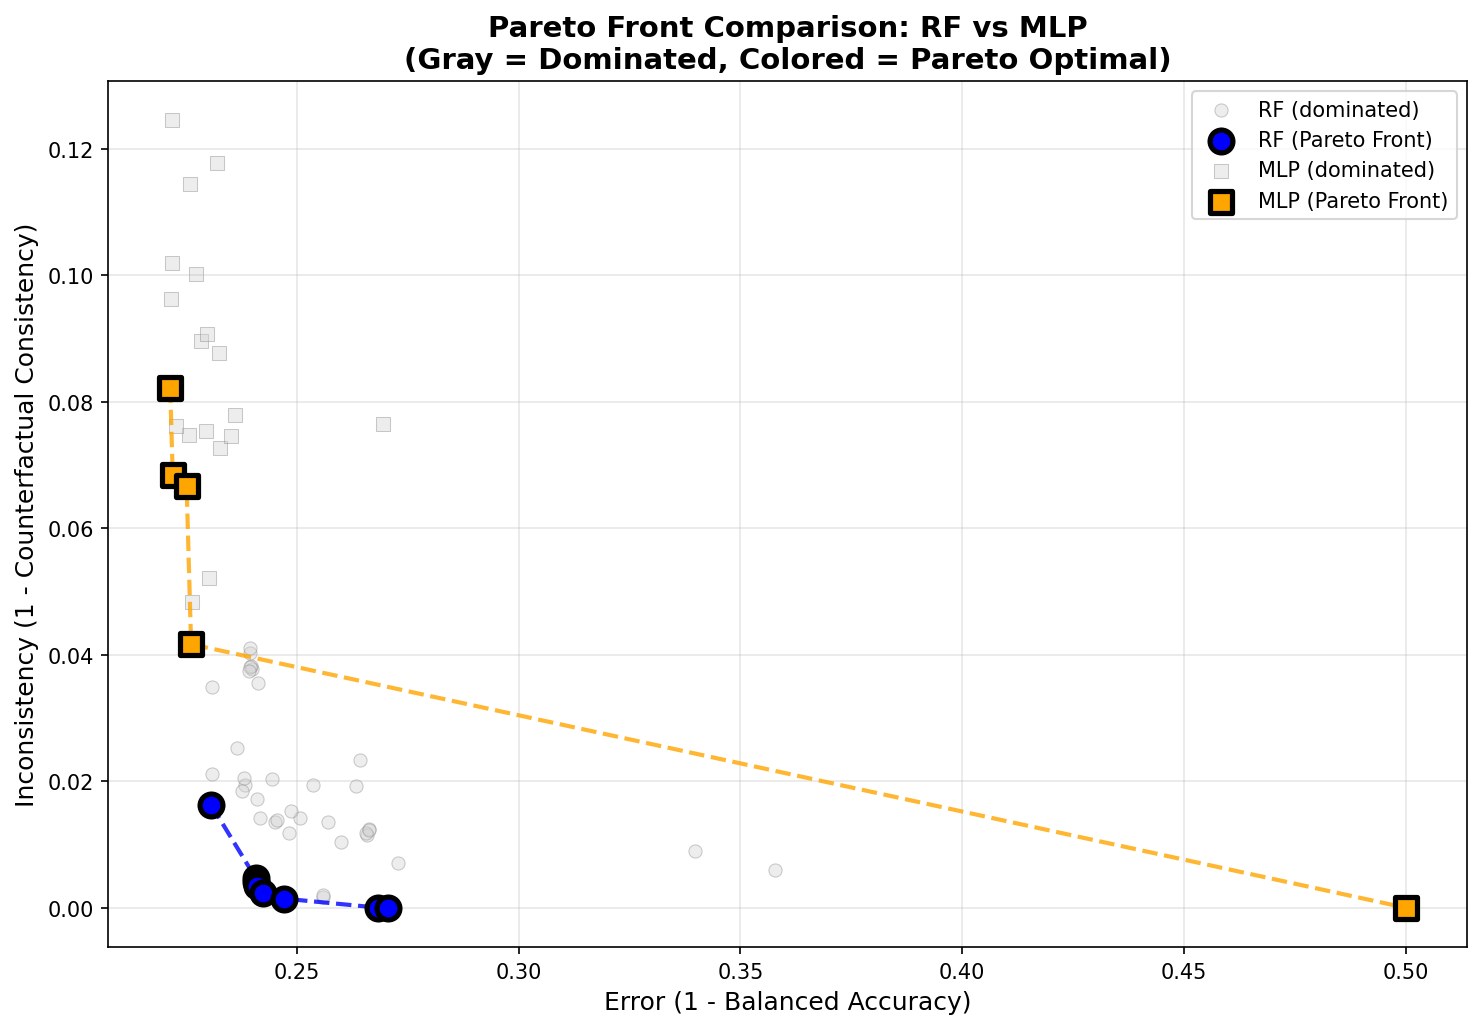

In [52]:
# Generate Pareto comparison plot for Approach 2
# Note: plot_pareto_comparison only supports rf/mlp currently
# We'll create a custom plot if SenSeI is included

pareto_path_a2 = f"{OUTPUT_DIR}/pareto_{DATASET_NAME_A2}_approach2.png"

# Filter to only RF and MLP for the standard plot function
results_a2_standard = {k: v for k, v in results_a2.items() if k in ["rf", "mlp"]}
plot_pareto_comparison(results_a2_standard, output_path=pareto_path_a2)

print("\nApproach 2 - Pareto Front Comparison (RF vs MLP):")
display(Image(filename=pareto_path_a2))


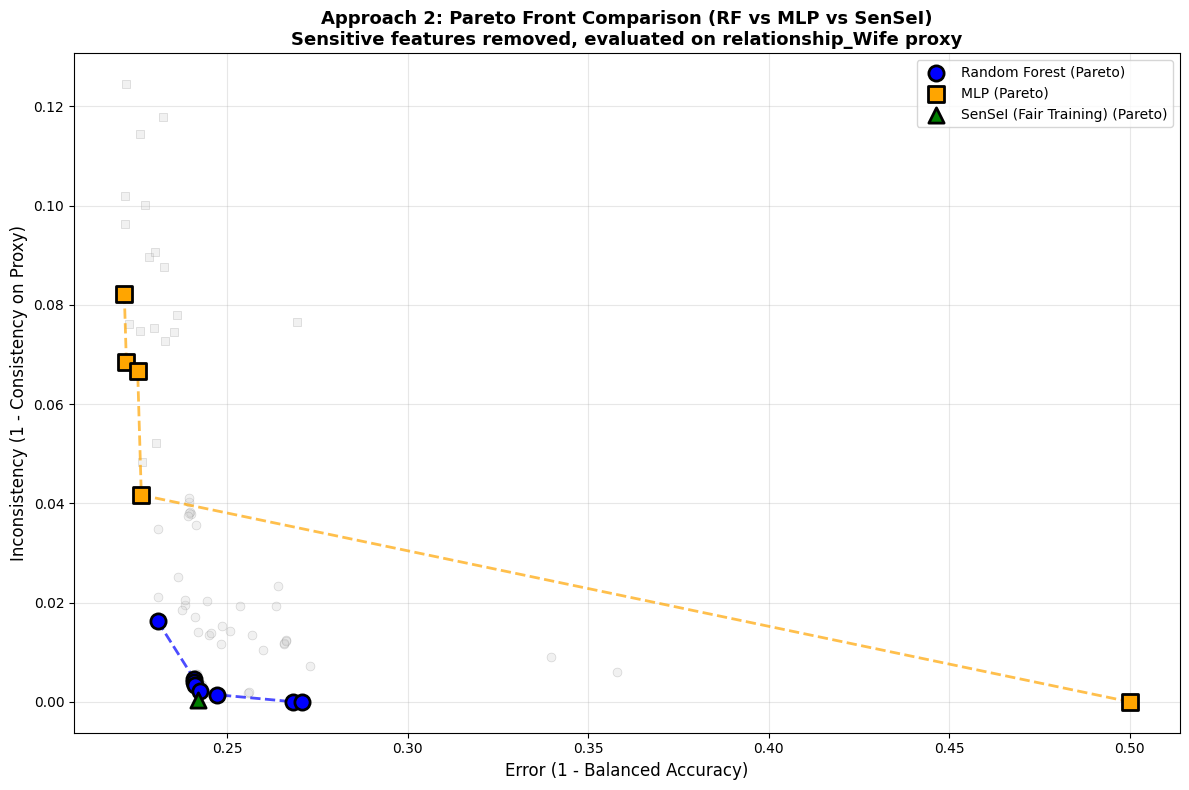

Plot saved to: ../plots/pareto_adult_approach2_with_sensei.png


In [53]:
# If SenSeI was optimized, create a combined Pareto plot including all 3 models
if "sensei" in results_a2:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
    markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}
    labels = {'rf': 'Random Forest', 'mlp': 'MLP', 'sensei': 'SenSeI (Fair Training)'}
    
    for model_type, smac in results_a2.items():
        # Get Pareto front
        configs, pareto_costs = get_pareto_front(smac)
        
        # Get all costs
        all_costs = np.array([smac.runhistory.average_cost(c) 
                             for c in smac.runhistory.get_configs()])
        
        # Plot all points (faded)
        ax.scatter(
            all_costs[:, 0], all_costs[:, 1],
            c='lightgray', marker=markers[model_type],
            alpha=0.3, s=40, edgecolors='gray', linewidths=0.5,
            zorder=1
        )
        
        # Plot Pareto front (highlighted)
        ax.scatter(
            pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], marker=markers[model_type],
            s=120, edgecolors='black', linewidths=2,
            label=f'{labels[model_type]} (Pareto)',
            zorder=3
        )
        # Connect Pareto points
        ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
                c=colors[model_type], linestyle='--', linewidth=2, alpha=0.7, zorder=2)
    
    ax.set_xlabel('Error (1 - Balanced Accuracy)', fontsize=12)
    ax.set_ylabel('Inconsistency (1 - Consistency on Proxy)', fontsize=12)
    ax.set_title('Approach 2: Pareto Front Comparison (RF vs MLP vs SenSeI)\n'
                 'Sensitive features removed, evaluated on relationship_Wife proxy',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    sensei_pareto_path = f"{OUTPUT_DIR}/pareto_{DATASET_NAME_A2}_approach2_with_sensei.png"
    plt.savefig(sensei_pareto_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {sensei_pareto_path}")
else:
    print("SenSeI not included in results - skipping combined plot")


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_rf.png

Approach 2 - Random Forest Parallel Coordinate Plot:


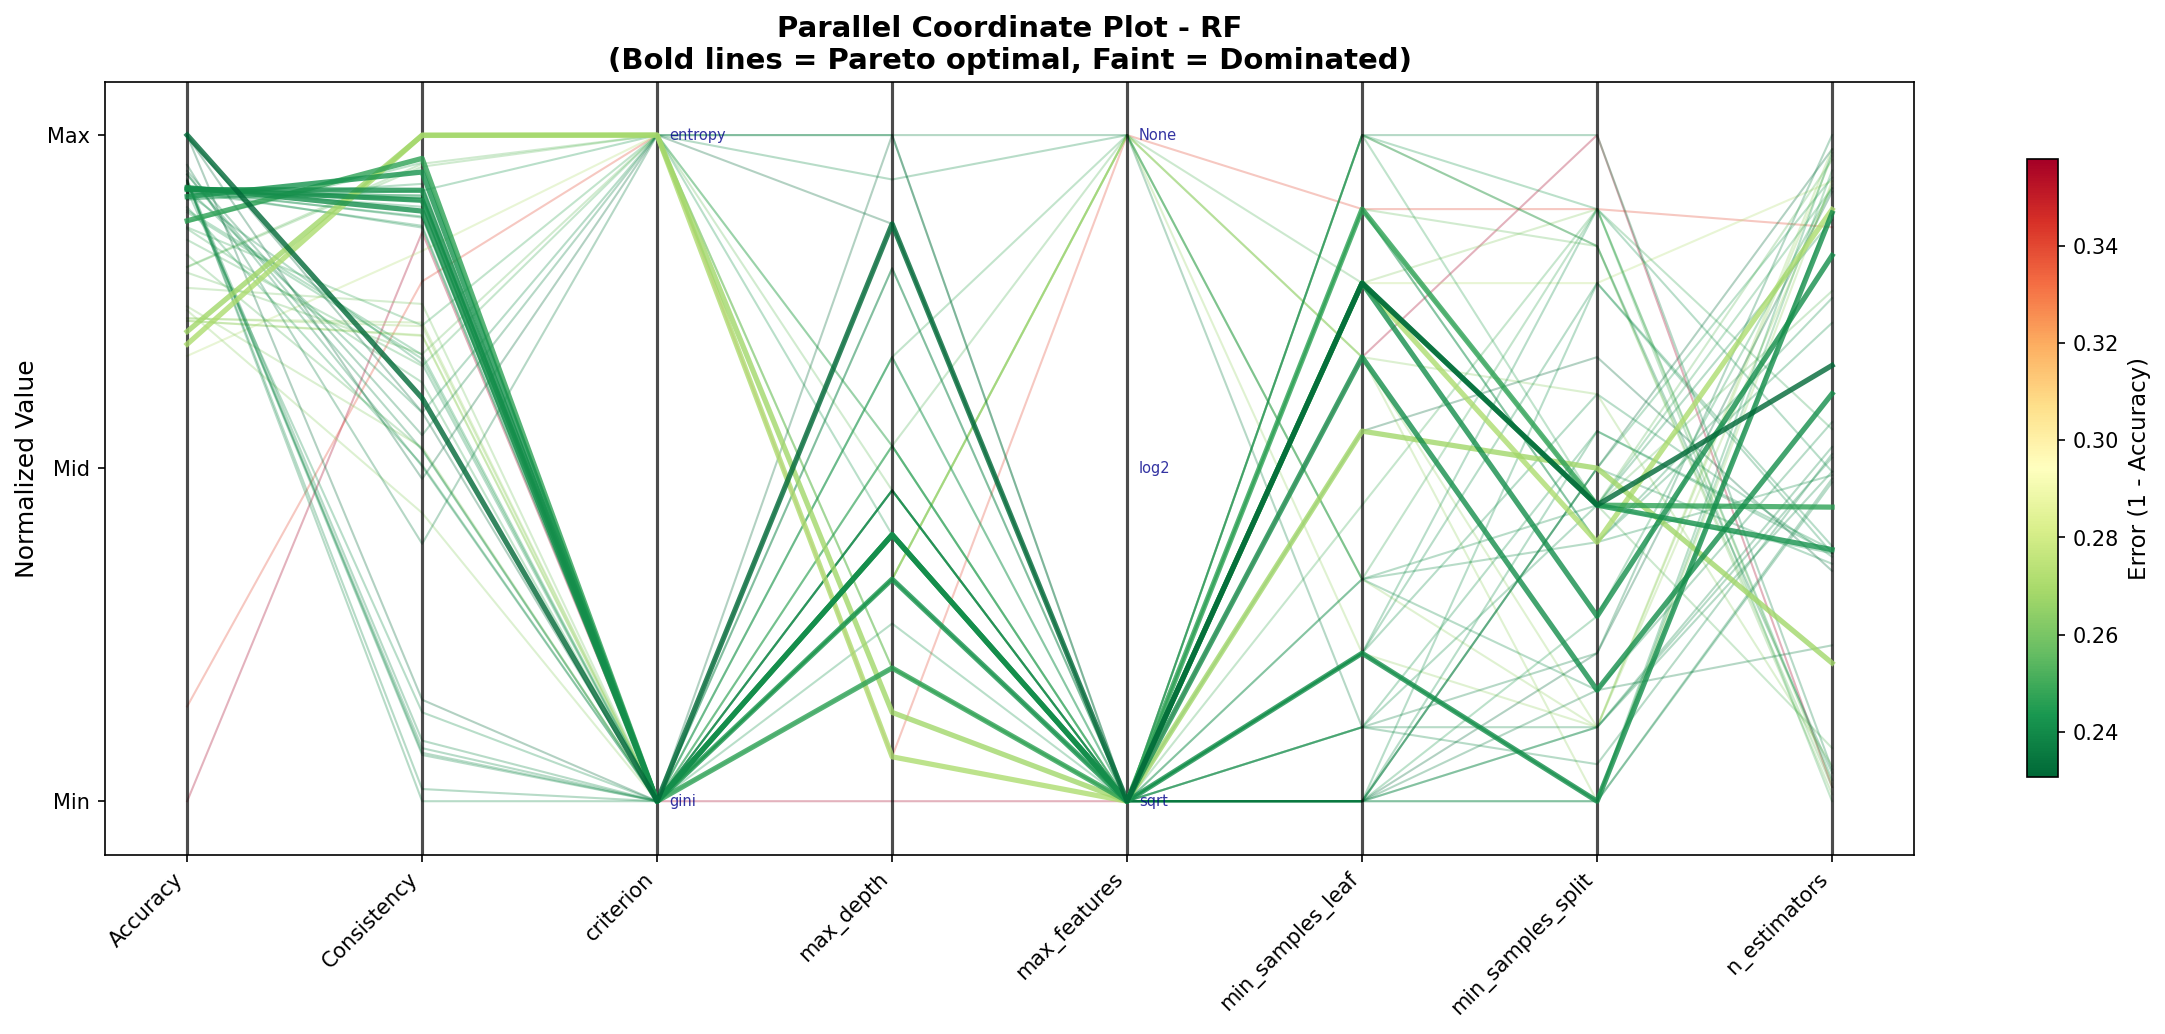

In [54]:
# Approach 2 - Random Forest Parallel Coordinates
rf_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_rf.png"
plot_parallel_coordinates(results_a2['rf'], 'rf', output_path=rf_parallel_path_a2, color_by='error')

print("\nApproach 2 - Random Forest Parallel Coordinate Plot:")
display(Image(filename=rf_parallel_path_a2))


Parallel coordinate plot saved to: ../plots/parallel_coords_adult_approach2_mlp.png

Approach 2 - MLP Parallel Coordinate Plot:


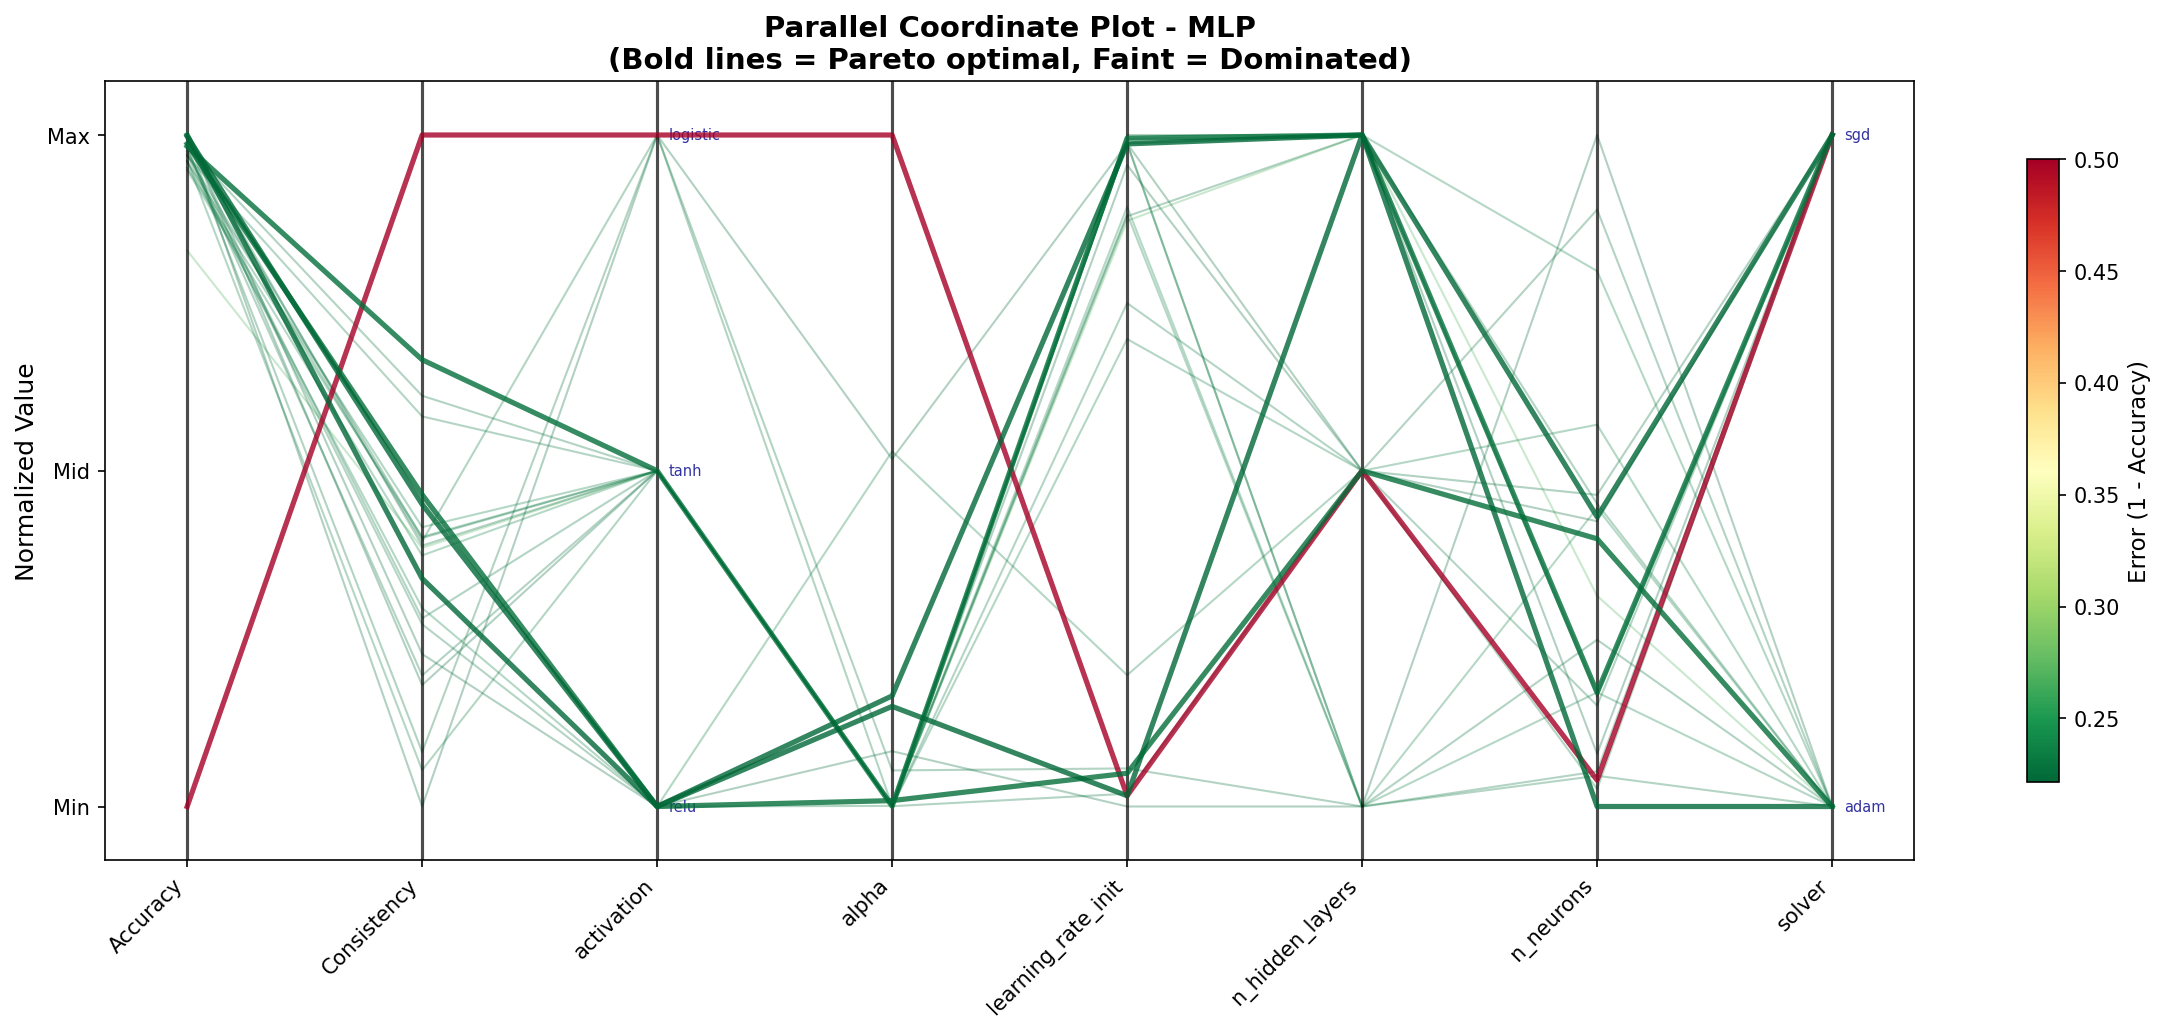

In [55]:
# Approach 2 - MLP Parallel Coordinates
mlp_parallel_path_a2 = f"{OUTPUT_DIR}/parallel_coords_{DATASET_NAME_A2}_approach2_mlp.png"
plot_parallel_coordinates(results_a2['mlp'], 'mlp', output_path=mlp_parallel_path_a2, color_by='error')

print("\nApproach 2 - MLP Parallel Coordinate Plot:")
display(Image(filename=mlp_parallel_path_a2))


MDS projection plot saved to: ../plots/mds_projection_adult_approach2_rf.png

Approach 2 - Random Forest MDS Projection:


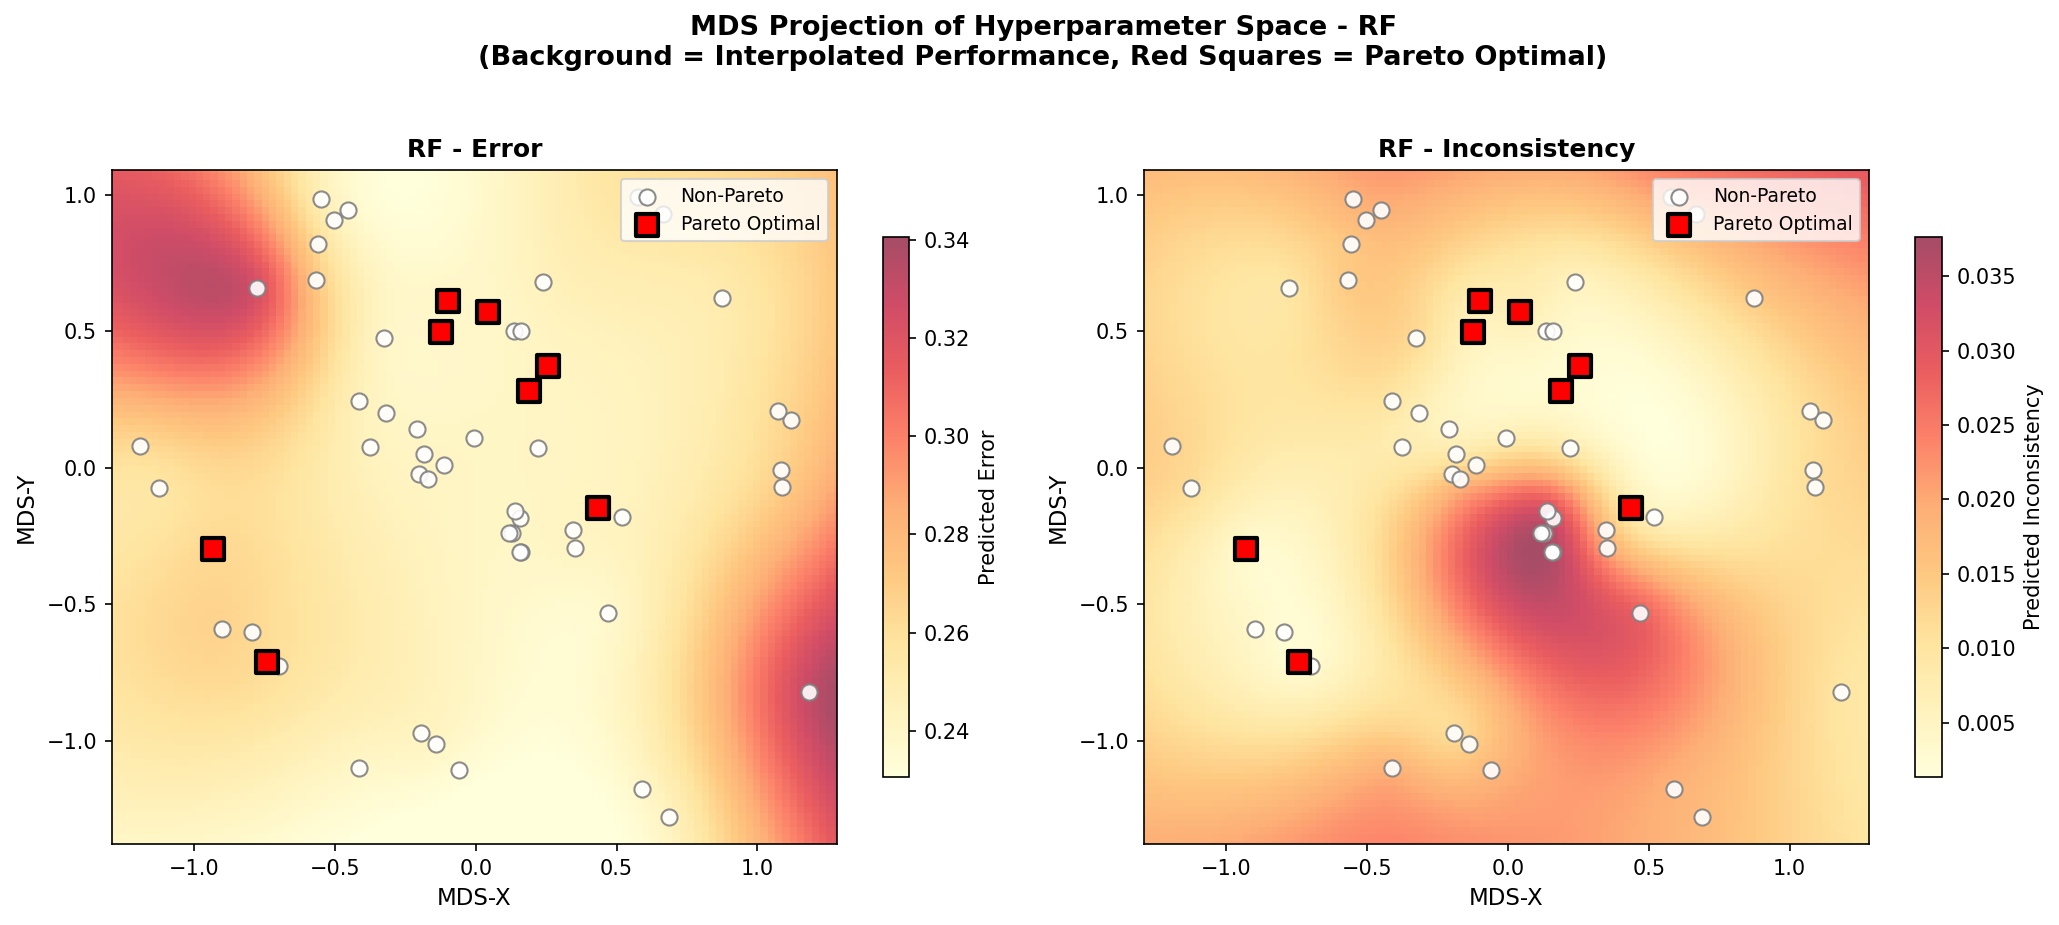

In [56]:
# Approach 2 - Random Forest MDS Projection
rf_mds_path_a2 = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME_A2}_approach2_rf.png"
plot_mds_projection(results_a2['rf'], 'rf', output_path=rf_mds_path_a2)

print("\nApproach 2 - Random Forest MDS Projection:")
display(Image(filename=rf_mds_path_a2))


In [ ]:
# Compare best configurations from Approach 1 vs Approach 2
print("=" * 80)
print("COMPARISON: Approach 1 vs Approach 2 - Best Configurations")
print("=" * 80)

def get_best_configs(results_dict, approach_name):
    """Extract best accuracy and best fairness configs from results."""
    print(f"\n{approach_name}:")
    print("-" * 60)
    
    for model_type, smac in results_dict.items():
        configs, costs = get_pareto_front(smac)
        
        # Best accuracy
        best_acc_idx = np.argmin(costs[:, 0])
        best_acc = 1 - costs[best_acc_idx, 0]
        best_acc_cons = 1 - costs[best_acc_idx, 1]
        
        # Best consistency
        best_cons_idx = np.argmin(costs[:, 1])
        best_cons = 1 - costs[best_cons_idx, 1]
        best_cons_acc = 1 - costs[best_cons_idx, 0]
        
        print(f"\n  {model_type.upper()}:")
        print(f"    Best Accuracy:    Acc={best_acc:.4f}, Cons={best_acc_cons:.4f}")
        print(f"    Best Consistency: Acc={best_cons_acc:.4f}, Cons={best_cons:.4f}")

# Approach 1 (with sensitive features, flip sex)
get_best_configs(results, "APPROACH 1 (With Sensitive Features, Flip Sex)")

# Approach 2 (without sensitive features, flip proxy)
get_best_configs(results_a2, "APPROACH 2 (Without Sensitive Features, Flip Proxy)")


In [ ]:
# Visual comparison: Approach 1 vs Approach 2 side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Common settings
colors = {'rf': 'blue', 'mlp': 'orange', 'sensei': 'green'}
markers = {'rf': 'o', 'mlp': 's', 'sensei': '^'}

# Plot Approach 1
ax = axes[0]
for model_type, smac in results.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 1: WITH Sensitive Features\n(Flip sex directly)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot Approach 2
ax = axes[1]
for model_type, smac in results_a2.items():
    configs, pareto_costs = get_pareto_front(smac)
    ax.scatter(pareto_costs[:, 0], pareto_costs[:, 1],
               c=colors[model_type], marker=markers[model_type],
               s=100, edgecolors='black', linewidths=1.5,
               label=f'{model_type.upper()}')
    ax.plot(pareto_costs[:, 0], pareto_costs[:, 1],
            c=colors[model_type], linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Error (1 - Accuracy)', fontsize=11)
ax.set_ylabel('Inconsistency (1 - Consistency)', fontsize=11)
ax.set_title('Approach 2: WITHOUT Sensitive Features\n(Flip proxy: relationship_Wife)', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Match axis limits for comparison
all_errors = []
all_incons = []
for res in [results, results_a2]:
    for smac in res.values():
        configs, costs = get_pareto_front(smac)
        all_errors.extend(costs[:, 0])
        all_incons.extend(costs[:, 1])

err_min, err_max = min(all_errors) - 0.02, max(all_errors) + 0.02
inc_min, inc_max = min(all_incons) - 0.02, max(all_incons) + 0.02

for ax in axes:
    ax.set_xlim(err_min, err_max)
    ax.set_ylim(inc_min, inc_max)

plt.suptitle('Comparison: Approach 1 vs Approach 2', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/comparison_approach1_vs_approach2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved to: {OUTPUT_DIR}/comparison_approach1_vs_approach2.png")


In [ ]:
# Approach 2 - MLP MDS Projection
mlp_mds_path_a2 = f"{OUTPUT_DIR}/mds_projection_{DATASET_NAME_A2}_approach2_mlp.png"
plot_mds_projection(results_a2['mlp'], 'mlp', output_path=mlp_mds_path_a2)

print("\nApproach 2 - MLP MDS Projection:")
display(Image(filename=mlp_mds_path_a2))
